# Предсказание ДТП

## Описание проекта

В каршеринговой компании возникла идея создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.  

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.  
Идея решения задачи от заказчика:  
Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties).  
Для модели выбрать тип виновника — только машина (car).  
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
Для моделирования ограничиться данными за 2012 год — они самые свежие.  
Обязательное условие — учесть фактор возраста автомобиля.  
На основе модели исследовать основные факторы ДТП.  
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:  
Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?  
Какие ещё факторы нужно учесть?  
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Модели на основе градиентного бустинга
from catboost import (
    CatBoostClassifier,
    cv as cb_cv,
    Pool)
from catboost.utils import get_roc_curve, select_threshold

from lightgbm import (
    LGBMClassifier,
    cv as lgbm_cv,
    plot_importance)

# Не будем ограничиваться градиентным бустингом. Попробуем более простые модели: линейной регрессии и случайного леса
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    roc_auc_score,       # Расчёт AUC ROC
    roc_curve,           # Построение ROC-кривой
    confusion_matrix     # Вычисление tn, fp, fn, tp
)

# Для масштабирования и кодирования признаков
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)



TABLES = {'collisions':'(информация о происшествиях)',
          'Parties':'(описание участников происшествия)',
          'Vehicles':'(Описание автомобиля)',
          'case_ids':'(номера происшествий)'
          }
RANDOM_STATE = 12345

## Подключение к базе. Загрузка таблиц sql

In [2]:
# Конфигурация для подключения к базе данных
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}   

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
# Подключимся к базе данных
engine = create_engine(connection_string)

## Первичное исследование таблиц

In [4]:
# Рассмотрим первые строки таблиц
for table in TABLES.keys():
    query = '''
    SELECT *
    FROM ''' + table + ' LIMIT 5'
    print(f'Таблица {table: <10} {TABLES[table]: <35}')
    print()
    print(pd.read_sql_query(query, con=engine))
    print()

Таблица collisions (информация о происшествиях)       

   case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   
2             1     clear          None          scratch            2   
3             1     clear          None          scratch            2   
4             1     clear          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   v

Все колонки в таблицах соответствуют схеме базы данных. Убедимся в том, что case_id является ключом для связи таблиц.

In [5]:
# Посмотрим количество записей в таблицах
print('Количество записей в таблицах:')
for table in TABLES.keys():
    query = '''
    SELECT COUNT(*)
    FROM ''' + table
    print(f'{table: <10} {TABLES[table]: <35} {pd.read_sql_query(query, con=engine).values.flatten()[0]: <}')

Количество записей в таблицах:
collisions (информация о происшествиях)        1400000
Parties    (описание участников происшествия)  2752408
Vehicles   (Описание автомобиля)               1021234
case_ids   (номера происшествий)               1400000


Если поле `case_id` является ключом для связи всех таблиц, то должны выполняться условия:
- количество записей в результате объединения оператором INNER JOIN таблиц `case_ids`, `Parties`, `collisions` по ключу `case_id` должно составить 1400000 при выборе уникальных значений `case_id`,  и 2752408 при подсчёте всех строк объединения, т.к. таблица `case_ids` содержит все значения идентификаторов происшествий, а значит в таблицах `Parties`, `collisions` должны все эти идентификаторы присутствовать. При этом значения `case_id` в таблице `case_ids` должны быть уникальными,
- количество записей в результате объединения оператором INNER JOIN таблиц `Parties` и `Vehicles` по ключам `case_id` и `party_number` (уникальныная комбинация для участника ДТП и для описания автомобиля) должно составить 1021234, т.к. таблица `Vehicles` содержит идентификаторы всех машин, а значит в таблице `Parties` должны все такие же идентификаторы и номера участников присутствовать.

In [6]:
# Проверим первое условие
query = '''
SELECT COUNT(DISTINCT c_i.case_id)
FROM case_ids AS c_i
INNER JOIN collisions AS c ON c_i.case_id = c.case_id
INNER JOIN Parties AS p ON c.case_id = p.case_id
'''
print('Количество строк с уникальными case_id',
      pd.read_sql_query(query, con=engine).values.flatten()[0])
query = '''
SELECT COUNT(*)
FROM case_ids AS c_i
INNER JOIN collisions AS c ON c_i.case_id = c.case_id
INNER JOIN Parties AS p ON c.case_id = p.case_id
'''
print('Количество строк со всеми case_id     ',
      pd.read_sql_query(query, con=engine).values.flatten()[0])

Количество строк с уникальными case_id 1400000
Количество строк со всеми case_id      2752408


In [7]:
# Проверим второе условие
query = '''
SELECT COUNT(*)
FROM (SELECT case_id, party_number
      FROM vehicles
      GROUP BY case_id, party_number) AS vehicles
INNER JOIN (SELECT case_id, party_number
            FROM Parties
            GROUP BY case_id, party_number) AS cars
      ON vehicles.case_id = cars.case_id AND vehicles.party_number = cars.party_number
'''
print(pd.read_sql_query(query, con=engine).values.flatten()[0])


1021234


Выводы:
- таблицы и колонки в таблицах соответствуют схеме базы данных,
- имеется общий ключ `case_id` для связи таблиц,
- в таблицах имеются данные.

##  Проведите статистический анализ факторов ДТП

In [8]:
# Определим функцию, которая визуализирует частотность серьёзности повреждений при
# определённом значении фактора и частота ДТП при разных значениях фактора 
def factors_of_damage_show(data, factor, ax, rotation, vert):
    ax.set_title(f'Относительная частота серьёзности повреждений. Исследуемый фактор: {factor}', fontsize=14)
    ax.grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')
    if vert == True:
        ax.set_yscale('log')
        ax.set_ylabel('Относительная частота серьёзности повреждений')
        x_axis = np.arange(data.shape[0])
        ax.set_xticks(x_axis)
        ax.set_xticklabels(list(data.index), rotation=rotation)
    else:
        ax.set_xscale('log')
        ax.set_xlabel('Относительная частота серьёзности повреждений')
        y_axis = np.arange(data.shape[0])        
        ax.set_yticks(y_axis)
        ax.set_yticklabels(list(data.index), rotation=rotation)
    i=0
    for col in data.columns:
        if col == 'scratch':
            color = 'lightgreen'
        if col == 'small damage':
            color = 'green'
        if col == 'severe damage':
            color = 'orange'
        if col == 'middle damage':
            color = 'yellow'
        if col == 'fatal':
            color = 'red'
        if col == 'total_frequency':
            color = 'grey'            
        if color == 'yellow':
            edgecolor = 'black'
        else:
            edgecolor = None
        if vert == True:     
            ax.bar(x=x_axis-0.1*i, height=data[col], width=0.1,
                   align='edge', label=col, color=color, linestyle = '-', edgecolor = edgecolor)
        else:
            ax.barh(y=y_axis-0.15*i, width=data[col], height=0.15,
                    align='edge', label=col, color=color, linestyle = '-', edgecolor = edgecolor)
        i += 1
    ax.legend()

In [9]:
# Определим функцию, которая визуализирует частотность значений какого-то фактора у виновника ДТП
# и у остальных участников
def fault_and_others_show(data, factor, ax, rotation, vert):
    ax.set_title(f'Виновник ДТП и другие участники ДТП. Исследуемый фактор: {factor}', fontsize=14)
    ax.grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')
    if vert == True:
        ax.set_yscale('log')
        ax.set_ylabel('Относительная частота значений фактора')
        x_axis = np.arange(data.shape[0])
        ax.set_xticks(x_axis)
        ax.set_xticklabels(list(data.index))
        ax.bar(x=x_axis-0.15, height=data['участник'], width=0.25, align='center', label='участник')
        ax.bar(x=x_axis+0.15, height=data['виновник'], width=0.25, align='center', label='виновник')
    else:    
        ax.set_xscale('log')
        ax.set_xlabel('Относительная частота значений фактора')
        y_axis = np.arange(data.shape[0])
        ax.set_yticks(y_axis)
        ax.set_yticklabels(list(data.index))
        ax.barh(y=y_axis-0.15, width=data['участник'], height=0.25, align='center', label='участник')
        ax.barh(y=y_axis+0.15, width=data['виновник'], height=0.25, align='center', label='виновник')
    ax.legend()

###  Количество аварий по месяцам

Выясним, в какие месяцы происходит наибольшее количество аварий. Проанализируем весь период наблюдений.

In [10]:
# Рассмотрим за какой период имеются данные
print('Самая ранняя и самая поздняя даты')
query = '''
SELECT MIN (collision_date::date) AS min_date,
       MAX (collision_date::date) AS max_date
FROM collisions
'''
print(pd.read_sql_query(query, con=engine))
print()
query = '''
SELECT DATE_TRUNC('month', collision_date::date) AS month,
       COUNT(*) AS col_cnt
FROM collisions
GROUP BY DATE_TRUNC('month', collision_date::date)
ORDER BY DATE_TRUNC('month', collision_date::date)
'''
mothly_cnt = pd.read_sql_query(query, con=engine)
print(mothly_cnt)

Самая ранняя и самая поздняя даты
     min_date    max_date
0  2009-01-01  2020-07-26

                        month  col_cnt
0   2009-01-01 00:00:00+03:00    35062
1   2009-02-01 00:00:00+03:00    34480
2   2009-03-01 00:00:00+03:00    36648
3   2009-04-01 00:00:00+04:00    35239
4   2009-05-01 00:00:00+04:00    36916
5   2009-06-01 00:00:00+04:00    34202
6   2009-07-01 00:00:00+04:00    35161
7   2009-08-01 00:00:00+04:00    34508
8   2009-09-01 00:00:00+04:00    35555
9   2009-10-01 00:00:00+04:00    37835
10  2009-11-01 00:00:00+03:00    34562
11  2009-12-01 00:00:00+03:00    36060
12  2010-01-01 00:00:00+03:00    32892
13  2010-02-01 00:00:00+03:00    31918
14  2010-03-01 00:00:00+03:00    35803
15  2010-04-01 00:00:00+04:00    34416
16  2010-05-01 00:00:00+04:00    34862
17  2010-06-01 00:00:00+04:00    33367
18  2010-07-01 00:00:00+04:00    33645
19  2010-08-01 00:00:00+04:00    34620
20  2010-09-01 00:00:00+04:00    34957
21  2010-10-01 00:00:00+04:00    37480
22  2010-11-01 0

Данные имеются с января 2009 г. по июль 2020 г., при этом:
- начиная с июня 2012 количество ДТП за месяц резко снизилось,
- в 2013 г., в 2020 г. ДТП зафиксированы не во всех месяцах,
- за период 2014-2019 гг ДТП не зафиксированы.

Чтобы корректно оценить частоту ДТП в определённый месяц, найдём среднее, медианное и суммарное количество ДТП в определённый месяц. При этом будем брать только данные за период 01.2009 - 04.2012, в котором имеются адекватные данные по каждому месяцу.

In [11]:
# Выберем требуемые данные
query = '''
SELECT CASE EXTRACT(month FROM date)
            WHEN 1 THEN 'January'
            WHEN 2 THEN 'February'
            WHEN 3 THEN 'March'
            WHEN 4 THEN 'April'
            WHEN 5 THEN 'May'
            WHEN 6 THEN 'June'
            WHEN 7 THEN 'July'
            WHEN 8 THEN 'August'
            WHEN 9 THEN 'September'
            WHEN 10 THEN 'October'
            WHEN 11 THEN 'November'
            WHEN 12 THEN 'December'
       END AS month,
       ROUND(percentile_cont(0.5) within group (order by col_cnt)) AS col_median,
       ROUND(AVG(col_cnt)) AS col_mean,
       ROUND(SUM(col_cnt)) AS col_sum
FROM (SELECT DATE_TRUNC('month', collision_date::date) AS date,
             COUNT(*) AS col_cnt
      FROM collisions
      WHERE collision_date::date < '2012-05-01'
      GROUP BY DATE_TRUNC('month', collision_date::date)
      ORDER BY DATE_TRUNC('month', collision_date::date)) AS collisions_by_months
GROUP BY EXTRACT(month FROM date)
'''
mothly_cnt = pd.read_sql_query(query, con=engine)
print(mothly_cnt)

        month  col_median  col_mean   col_sum
0     January     32456.0   32975.0  131900.0
1    February     31946.0   32188.0  128750.0
2       March     35194.0   34884.0  139534.0
3       April     32896.0   32544.0  130175.0
4         May     34862.0   35049.0  105148.0
5        June     33367.0   33177.0   99531.0
6        July     33645.0   33945.0  101835.0
7      August     34508.0   34489.0  103467.0
8   September     34957.0   34883.0  104649.0
9     October     37480.0   37311.0  111933.0
10   November     34562.0   34839.0  104517.0
11   December     36060.0   35915.0  107745.0


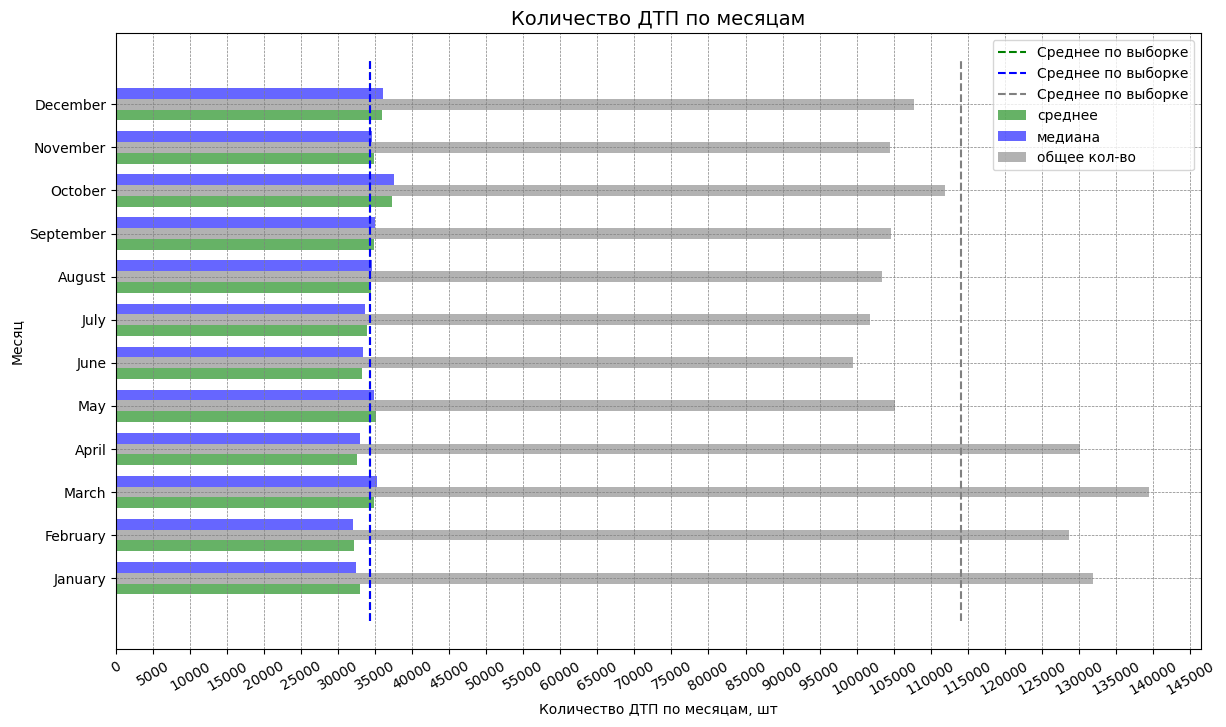

In [12]:
# Построим график для визуализации данных
plt.figure(figsize=(14,8))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
plt.title('Количество ДТП по месяцам', fontsize=14)
plt.xticks(range(0, 150000, 5000))
y_axe = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xticks(rotation=30)
plt.yticks(y_axe, labels=mothly_cnt['month'])
plt.xlabel('Количество ДТП по месяцам, шт')
plt.ylabel('Месяц')
# Средние значения
plt.barh(y=y_axe-0.25, width=mothly_cnt['col_mean'], height=0.25,
         align='center',  label='среднее', color='green', alpha=0.6)
plt.plot([mothly_cnt['col_mean'].mean(), mothly_cnt['col_mean'].mean()],
         [0, 13], linestyle='--', color='green', label='Среднее по выборке')
# Медианные значения
plt.barh(y=y_axe+0.25, width=mothly_cnt['col_median'], height=0.25,
         align='center', label='медиана', color='blue', alpha=0.6)
plt.plot([mothly_cnt['col_median'].mean(), mothly_cnt['col_median'].mean()],
         [0, 13], linestyle='--', color='blue', label='Среднее по выборке')
# Сумарное количество
plt.barh(y=y_axe, width=mothly_cnt['col_sum'], height=0.25,
         align='center', label='общее кол-во', color='grey', alpha=0.6)
plt.plot([mothly_cnt['col_sum'].mean(), mothly_cnt['col_sum'].mean()],
         [0, 13], linestyle='--', color='grey', label='Среднее по выборке')
plt.legend()
plt.show()

Вывод:
- наибольшее количество ДТП зафиксировано в марте, схожее количество зафиксировано в январе, феврале, апреле, мае,
- наибольшее медианное количество ДТП зафиксировано в октябре, также медианное количество ДТП выше среднего значения медианы по выборке в марте и декабре,
- наибольшее среднее количество ДТП зафиксировано в октябре, также среднее количество ДТП выше среднего значения среднего количества ДТП за месяц по выборке в марте и декабре.

Исходя из вышеизложенного можем заключить, что наибольшее количество аварий происходит в октябре. Количество аварий выше среднего - в декабре и марте.

###  Количество аварий по дням недели и месяца

Выясним, в какие дни недели и месяца происходит наибольшее количество аварий. Проанализируем весь период наблюдений. Определим суммарное число аварий по дням недели и месяца.

In [13]:
# Выберем требуемые данные по дням недели
query = '''
SELECT CASE dow
           WHEN 1 THEN 'Monday'
           WHEN 2 THEN 'Tuesday'
           WHEN 3 THEN 'Wednesday'
           WHEN 4 THEN 'Thursday'
           WHEN 5 THEN 'Friday'
           WHEN 6 THEN 'Saturday'
           WHEN 7 THEN 'Sunday'
       END AS dow,
       col_cnt
FROM (SELECT CASE EXTRACT(dow FROM collision_date::date)
                 WHEN 0 THEN 7
                 WHEN 1 THEN 1
                 WHEN 2 THEN 2
                 WHEN 3 THEN 3
                 WHEN 4 THEN 4
                 WHEN 5 THEN 5
                 WHEN 6 THEN 6
             END AS dow,
             COUNT(*) AS col_cnt
      FROM collisions
      GROUP BY dow
      ORDER BY dow) AS collisions_by_dow
'''
dow_cnt = pd.read_sql_query(query, con=engine)
print(dow_cnt)

         dow  col_cnt
0     Monday   195282
1    Tuesday   206914
2  Wednesday   206775
3   Thursday   206823
4     Friday   229048
5   Saturday   191751
6     Sunday   163407


In [14]:
# Выберем требуемые данные по дням месяца
query = '''
SELECT EXTRACT(day FROM collision_date::date) AS day,
       COUNT(*) AS col_cnt
FROM collisions
GROUP BY day
ORDER BY day
'''
day_cnt = pd.read_sql_query(query, con=engine)
day_cnt['day'] = day_cnt['day'].astype('int')
print(day_cnt)

    day  col_cnt
0     1    47359
1     2    46692
2     3    46720
3     4    46584
4     5    46635
5     6    46664
6     7    46336
7     8    45294
8     9    46436
9    10    45754
10   11    44266
11   12    46591
12   13    47847
13   14    46716
14   15    46273
15   16    47715
16   17    48841
17   18    47116
18   19    46212
19   20    47755
20   21    46002
21   22    45771
22   23    47763
23   24    44791
24   25    43372
25   26    42794
26   27    45084
27   28    43542
28   29    40396
29   30    41441
30   31    25238


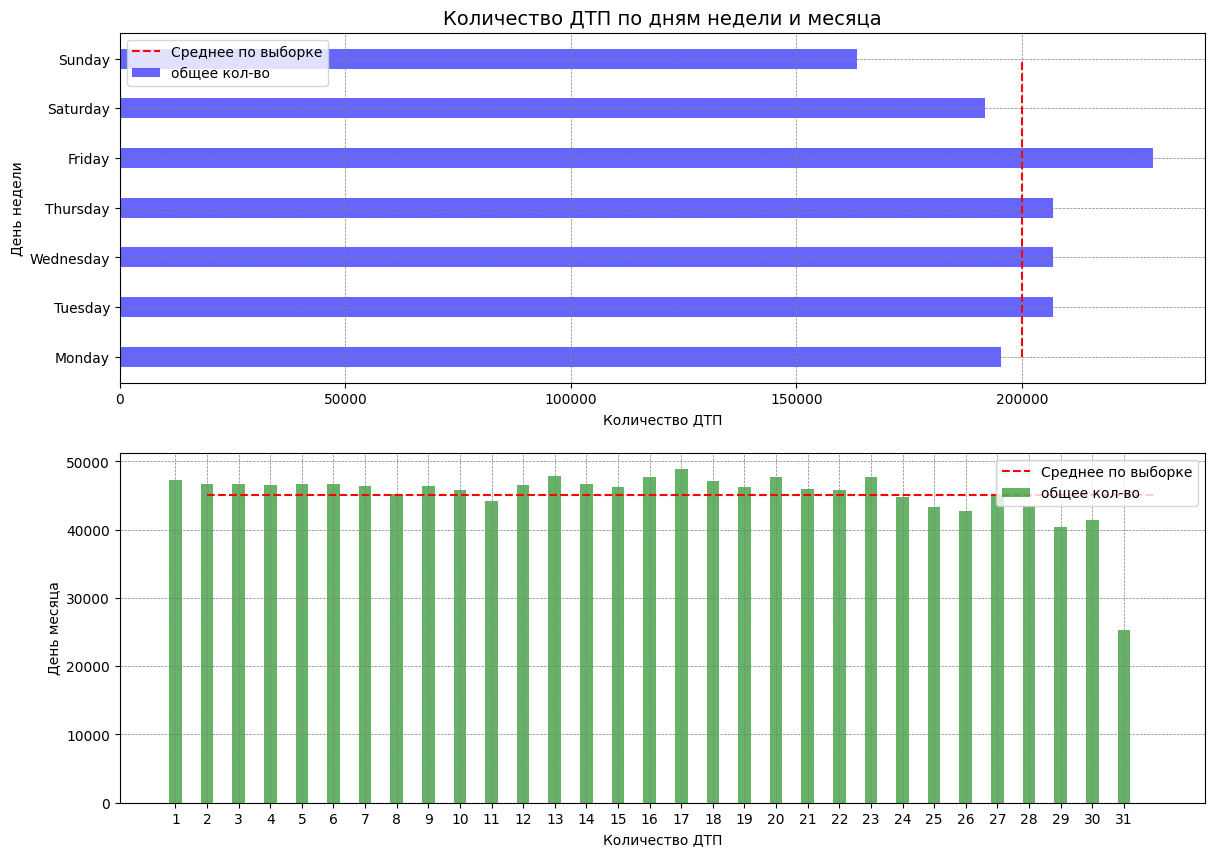

In [15]:
# Построим графики для визуализации данных
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={'height_ratios': (.5, .5)})
ax[0].set_title('Количество ДТП по дням недели и месяца', fontsize=14)
ax[0].grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')
ax[1].grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')

# По дням недели
ax[0].set_ylabel('День недели')
ax[0].set_xlabel('Количество ДТП')
y_axe = np.arange(dow_cnt.shape[0])
ax[0].set_yticks(y_axe)
ax[0].set_yticklabels(dow_cnt['dow'])
ax[0].barh(y=y_axe, width=dow_cnt['col_cnt'], height=0.4,
         align='center', label='общее кол-во', color='blue', alpha=0.6)
ax[0].plot([dow_cnt['col_cnt'].mean(), dow_cnt['col_cnt'].mean()],
         [0, 6], linestyle='--', color='red', label='Среднее по выборке')
ax[0].legend()

# По дням месяца
ax[1].set_ylabel('День месяца')
ax[1].set_xlabel('Количество ДТП')
x_axe = np.arange(day_cnt.shape[0])
ax[1].set_xticks(x_axe)
ax[1].set_xticklabels(day_cnt['day'])
ax[1].bar(x=x_axe, height=day_cnt['col_cnt'], width=0.4,
         align='center', label='общее кол-во', color='green', alpha=0.6)
ax[1].plot([1, 31],
           [day_cnt['col_cnt'].mean(), day_cnt['col_cnt'].mean()],
           linestyle='--', color='red', label='Среднее по выборке')
ax[1].legend()

plt.legend()
plt.show()

Вывод:
- наибольшее количество ДТП зафиксировано в пятницу, а наименьшее - в воскресенье, в субботу и понедельник количество ДТП ниже среднего,
- по дням месяца количество ДТП распределено равномерно, не считая 29-31 числа, что объясняется тем, что такие числа не в каждом месяце имеются. 

Исходя из вышеизложенного можем заключить, что наибольшее количество аварий происходит в пятницу, а от дня месяца количество аварий не зависит.

###  Повреждения и состояние дороги

Выясним, как связаны между собой состояние дороги (дорожная поверхность и прочее) в момент ДТП и серьёзность повреждений. Чтобы корректно оценить влияние состояния дороги, будем определять относительную частоту той или иной серьёзности повреждений при различных состояниях дороги.

In [16]:
# Выберем требуемые данные для оценки влияния поверхности
query = '''
SELECT road_surface,
       damage,
       count/SUM(count) OVER(PARTITION BY road_surface) AS relative_frequency,
       count/SUM(count) OVER() AS total_frequency
FROM   (SELECT road_surface,
               collision_damage AS damage,
               COUNT(*)
        FROM collisions
        GROUP BY road_surface, collision_damage
        ORDER BY road_surface, collision_damage) AS dmg_cnt
'''
road_data = pd.read_sql_query(query, con=engine)
road_data

road_surface         damage  relative_frequency  total_frequency
0           dry          fatal            0.007909         0.007016
1           dry  middle damage            0.121588         0.107868
2           dry        scratch            0.247952         0.219974
3           dry  severe damage            0.022405         0.019876
4           dry   small damage            0.600147         0.532427
5      slippery          fatal            0.008671         0.000009
6      slippery  middle damage            0.171965         0.000170
7      slippery        scratch            0.222543         0.000220
8      slippery  severe damage            0.046243         0.000046
9      slippery   small damage            0.550578         0.000544
10        snowy          fatal            0.006335         0.000033
11        snowy  middle damage            0.104944         0.000544
12        snowy        scratch            0.173392         0.000899
13        snowy  severe damage            0.021622         0.000112
14        snowy   small damage            0.693706         0.003598
15          wet          fatal            0.006291         0.000612
16          wet  middle damage            0.096817         0.009421
17          wet        scratch            0.244436         0.023786
18          wet  severe damage            0.018130         0.001764
19          wet   small damage            0.634326         0.061727
20         None          fatal            0.004201         0.000039
21         None  middle damage            0.105247         0.000984
22         None        scratch            0.250134         0.002339
23         None  severe damage            0.017490         0.000164
24         None   small damage            0.622928         0.005826

In [17]:
# Заполним пропуски заглушкой
road_data['road_surface'] = road_data['road_surface'].fillna('other')
# Агрегируем данные в сводную таблицу
road_data_g = road_data.pivot_table(values=['relative_frequency'], index=['road_surface'],
                                  columns=['damage'], aggfunc='first')
road_data_g.columns = road_data_g.columns.droplevel()
road_data = road_data_g.merge(road_data.pivot_table(values=['total_frequency'], index=['road_surface'],
                                        aggfunc='sum'),
                             left_index=True, right_index=True)
road_data = road_data.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                      ascending=False)
road_data

fatal  middle damage   scratch  severe damage  small damage  \
road_surface                                                                   
slippery      0.008671       0.171965  0.222543       0.046243      0.550578   
dry           0.007909       0.121588  0.247952       0.022405      0.600147   
snowy         0.006335       0.104944  0.173392       0.021622      0.693706   
wet           0.006291       0.096817  0.244436       0.018130      0.634326   
other         0.004201       0.105247  0.250134       0.017490      0.622928   

              total_frequency  
road_surface                   
slippery             0.000989  
dry                  0.887161  
snowy                0.005186  
wet                  0.097311  
other                0.009352

In [18]:
# Выберем требуемые данные для оценки влияния дороги
query = '''
SELECT road_condition,
       damage,
       count/SUM(count) OVER(PARTITION BY road_condition) AS relative_frequency,
       count/SUM(count) OVER() AS total_frequency
FROM   (SELECT road_condition_1 AS road_condition,
               collision_damage AS damage,
               COUNT(*)
        FROM collisions
        GROUP BY road_condition_1, collision_damage
        ORDER BY road_condition_1, collision_damage) AS dmg_cnt
'''
road_data_1 = pd.read_sql_query(query, con=engine)
road_data_1

road_condition         damage  relative_frequency  total_frequency
0     construction          fatal            0.009001         0.000124
1     construction  middle damage            0.096110         0.001327
2     construction        scratch            0.228688         0.003158
3     construction  severe damage            0.019088         0.000264
4     construction   small damage            0.647114         0.008936
5          flooded          fatal            0.005386         0.000004
6          flooded  middle damage            0.120287         0.000096
7          flooded        scratch            0.244165         0.000194
8          flooded  severe damage            0.017953         0.000014
9          flooded   small damage            0.612208         0.000487
10           holes          fatal            0.004194         0.000016
11           holes  middle damage            0.144602         0.000566
12           holes        scratch            0.248906         0.000975
13           holes  severe damage            0.030635         0.000120
14           holes   small damage            0.571663         0.002239
15  loose material          fatal            0.011777         0.000024
16  loose material  middle damage            0.194666         0.000401
17  loose material        scratch            0.176308         0.000364
18  loose material  severe damage            0.052996         0.000109
19  loose material   small damage            0.564254         0.001164
20          normal          fatal            0.007702         0.007409
21          normal  middle damage            0.119131         0.114591
22          normal        scratch            0.248019         0.238569
23          normal  severe damage            0.021861         0.021028
24          normal   small damage            0.603287         0.580300
25     obstruction          fatal            0.009287         0.000035
26     obstruction  middle damage            0.098749         0.000372
27     obstruction        scratch            0.182525         0.000688
28     obstruction  severe damage            0.024829         0.000094
29     obstruction   small damage            0.684610         0.002580
30           other          fatal            0.009494         0.000039
31           other  middle damage            0.141350         0.000574
32           other        scratch            0.214838         0.000873
33           other  severe damage            0.035513         0.000144
34           other   small damage            0.598805         0.002433
35   reduced width          fatal            0.006345         0.000007
36   reduced width  middle damage            0.088198         0.000099
37   reduced width        scratch            0.157995         0.000178
38   reduced width  severe damage            0.015863         0.000018
39   reduced width   small damage            0.731599         0.000824
40            None          fatal            0.005923         0.000051
41            None  middle damage            0.112112         0.000960
42            None        scratch            0.259343         0.002221
43            None  severe damage            0.020020         0.000171
44            None   small damage            0.602603         0.005160

In [19]:
# Заполним пропуски заглушкой
road_data_1['road_condition'] = road_data_1['road_condition'].fillna('other')
# Агрегируем данные в сводную таблицу
road_data_g = road_data_1.pivot_table(values=['relative_frequency'], index=['road_condition'],
                                      columns=['damage'], aggfunc='first')
road_data_g.columns = road_data_g.columns.droplevel()
road_data_1 = road_data_g.merge(road_data_1.pivot_table(values=['total_frequency'], index=['road_condition'],
                                        aggfunc='sum'),
                               left_index=True, right_index=True)
road_data_1 = road_data_1.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                      ascending=False)
road_data_1

fatal  middle damage   scratch  severe damage  \
road_condition                                                     
loose material  0.011777       0.194666  0.176308       0.052996   
other           0.009494       0.141350  0.214838       0.035513   
obstruction     0.009287       0.098749  0.182525       0.024829   
construction    0.009001       0.096110  0.228688       0.019088   
normal          0.007702       0.119131  0.248019       0.021861   
reduced width   0.006345       0.088198  0.157995       0.015863   
flooded         0.005386       0.120287  0.244165       0.017953   
holes           0.004194       0.144602  0.248906       0.030635   

                small damage  total_frequency  
road_condition                                 
loose material      0.564254         0.002062  
other               0.598805         0.012626  
obstruction         0.684610         0.003769  
construction        0.647114         0.013809  
normal              0.603287         0.961896  
reduced width       0.731599         0.001126  
flooded             0.612208         0.000796  
holes               0.571663         0.003917

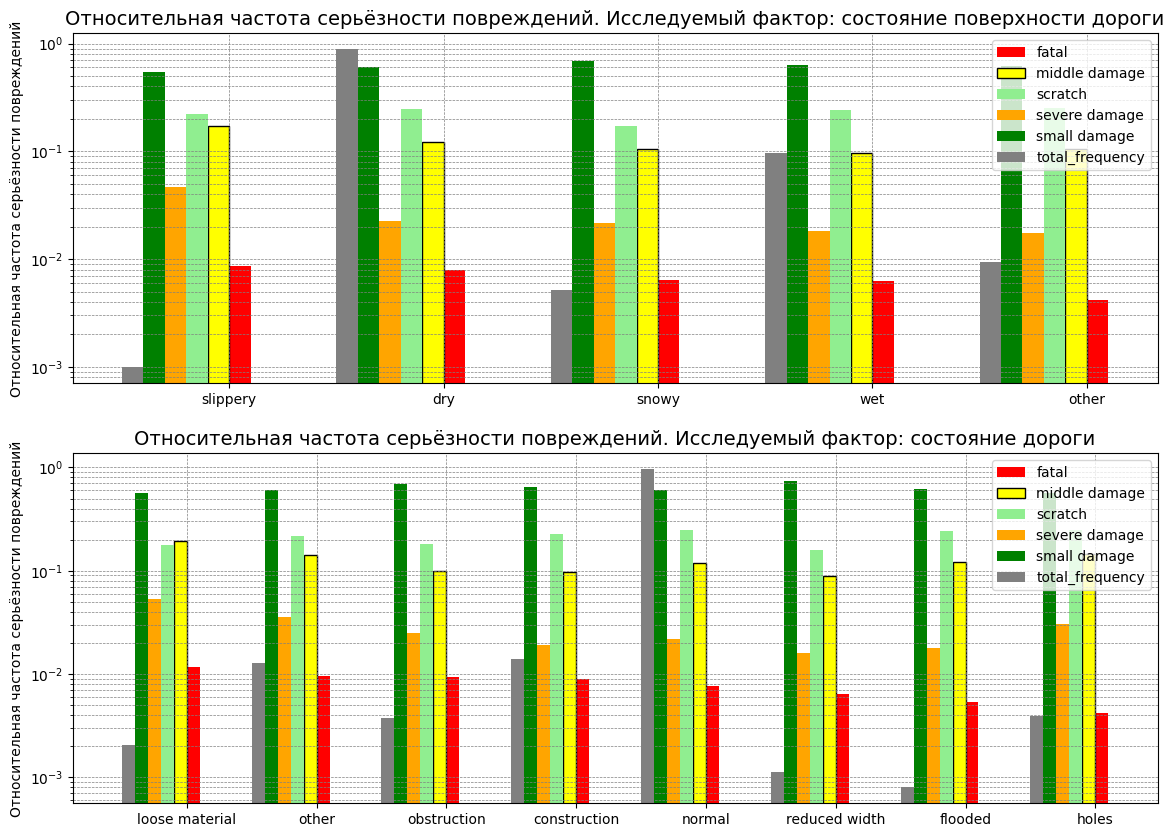

In [20]:
# Посмотрим, как связана тяжесть повреждений и состояние дороги
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={'height_ratios': (.5, .5)})

# В зависимости от состояния поверхности дороги
data = road_data
factor = 'состояние поверхности дороги'
rotation = 0
vert = True
factors_of_damage_show(data, factor, ax[0], rotation, vert)
# В зависимости от состояния дороги
data = road_data_1
factor = 'состояние дороги'
factors_of_damage_show(data, factor, ax[1], rotation, vert)
plt.show()

Выводы.
Наибольшая частота ДТП с самыми тяжёлыми последствиями (fatal, не подлежит восстановлению) наблюдается в случаях:
- дорога скользкая, грязная, маслянистая и т. д. или сухая,
- на проезжей части сыпучий материал, ведётся ремонт или строительство, имеется препятствие.

Наибольшая частота ДТП с тяжёлыми последствиями (severe, серьёзный ремонт, большая часть под замену/серьёзное повреждение капитального строения) наблюдается в случаях:
- дорога скользкая, грязная, маслянистая и т. д., сухая или заснеженная/обледенелая,
- на проезжей части сыпучий материал, яма или глубокая колея, имеется препятствие.

Наибольшая частота ДТП со средними повреждениями (middle, средний ремонт, машина в целом на ходу/Строение в целом устояло) наблюдается в случаях:
- дорога скользкая, грязная, маслянистая и т. д.,
- на проезжей части сыпучий материал, яма или глубокая колея, проезжая часть затоплена.

Незначительные повреждения и царапины наблюдаются приблизительно одинаково часто при различных состояниях дороги.

Чаще всего ДТП случались на сухой или мокрой дороге, без каких-то особенностей или на реконструируемых участках.  

Исходя из вышеизложенного можем заключить, что наибольшая частота серьёзных повреждений наблюдается в случаях, когда дорога  скользкая, грязная, маслянистая и т. д., на проезжей части имеется сыпучий материал, ямы, глубокая колея, препятствия, ведётся ремонт или строительство.

###  Наиболее частые причины ДТП

Выясним, какие факторы наиболее часто были причиной ДТП.

In [21]:
# Выберем требуемые данные
query = '''
SELECT primary_collision_factor,
       pcf_violation_category,
       count/SUM(count) OVER() AS relative_frequency
FROM   (SELECT primary_collision_factor,
               pcf_violation_category,
               COUNT(*)
        FROM collisions
        GROUP BY primary_collision_factor, pcf_violation_category
        ORDER BY primary_collision_factor, pcf_violation_category) AS factors
'''
factors = pd.read_sql_query(query, con=engine)
factors

primary_collision_factor             pcf_violation_category  \
0               fell asleep                        fell asleep   
1    other improper driving             other improper driving   
2         other than driver  other than driver (or pedestrian)   
3                   unknown                            unknown   
4    vehicle code violation            automobile right of way   
5    vehicle code violation                             brakes   
6    vehicle code violation                                dui   
7    vehicle code violation              following too closely   
8    vehicle code violation                  hazardous parking   
9    vehicle code violation                   impeding traffic   
10   vehicle code violation                   improper passing   
11   vehicle code violation                   improper turning   
12   vehicle code violation                             lights   
13   vehicle code violation                    other equipment   
14   vehicle code violation          other hazardous violation   
15   vehicle code violation                     pedestrian dui   
16   vehicle code violation            pedestrian right of way   
17   vehicle code violation               pedestrian violation   
18   vehicle code violation                           speeding   
19   vehicle code violation          traffic signals and signs   
20   vehicle code violation                            unknown   
21   vehicle code violation                 unsafe lane change   
22   vehicle code violation         unsafe starting or backing   
23   vehicle code violation                 wrong side of road   
24   vehicle code violation                               None   
25                     None                               None   

    relative_frequency  
0             0.000084  
1             0.006050  
2             0.021271  
3             0.026439  
4             0.113065  
5             0.000216  
6             0.078911  
7             0.021452  
8             0.001247  
9             0.000537  
10            0.008669  
11            0.170705  
12            0.000149  
13            0.001248  
14            0.009894  
15            0.000001  
16            0.011242  
17            0.010994  
18            0.313171  
19            0.051965  
20            0.001817  
21            0.067116  
22            0.039767  
23            0.024022  
24            0.014134  
25            0.005833

In [22]:
# Заполним пропуски заглушкой
factors['primary_collision_factor'] = factors['primary_collision_factor'].fillna('unknown')
factors['pcf_violation_category'] = factors['pcf_violation_category'].fillna('unknown')
# Объединим столбцы с причинами, объединим одинаковые значения причин, сложив частоты
factors.loc[(factors['primary_collision_factor']=='vehicle code violation')&(factors['pcf_violation_category']=='unknown'),
           'primary_collision_factor'] = 'unknown_violation'
factors.loc[(factors['primary_collision_factor']=='vehicle code violation'), 'primary_collision_factor'] = \
'violation-' + factors.loc[(factors['primary_collision_factor']=='vehicle code violation'), 'pcf_violation_category']
factors.loc[3, 'relative_frequency'] = \
factors.loc[factors['primary_collision_factor']=='unknown', 'relative_frequency'].sum()
factors.loc[20, 'relative_frequency'] = \
factors.loc[factors['primary_collision_factor']=='unknown_violation', 'relative_frequency'].sum()
factors = factors.loc[:23]
factors = factors.drop(['pcf_violation_category'], axis=1)
factors.columns = ['factor', 'relative_frequency']
factors = factors.sort_values(by=['relative_frequency'], ascending=False)
factors

factor  relative_frequency
18                    violation-speeding            0.313171
11            violation-improper turning            0.170705
4      violation-automobile right of way            0.113065
6                          violation-dui            0.078911
21          violation-unsafe lane change            0.067116
19   violation-traffic signals and signs            0.051965
22  violation-unsafe starting or backing            0.039767
3                                unknown            0.032271
23          violation-wrong side of road            0.024022
7        violation-following too closely            0.021452
2                      other than driver            0.021271
20                     unknown_violation            0.015951
16     violation-pedestrian right of way            0.011242
17        violation-pedestrian violation            0.010994
14   violation-other hazardous violation            0.009894
10            violation-improper passing            0.008669
1                 other improper driving            0.006050
13             violation-other equipment            0.001248
8            violation-hazardous parking            0.001247
9             violation-impeding traffic            0.000537
5                       violation-brakes            0.000216
12                      violation-lights            0.000149
0                            fell asleep            0.000084
15              violation-pedestrian dui            0.000001

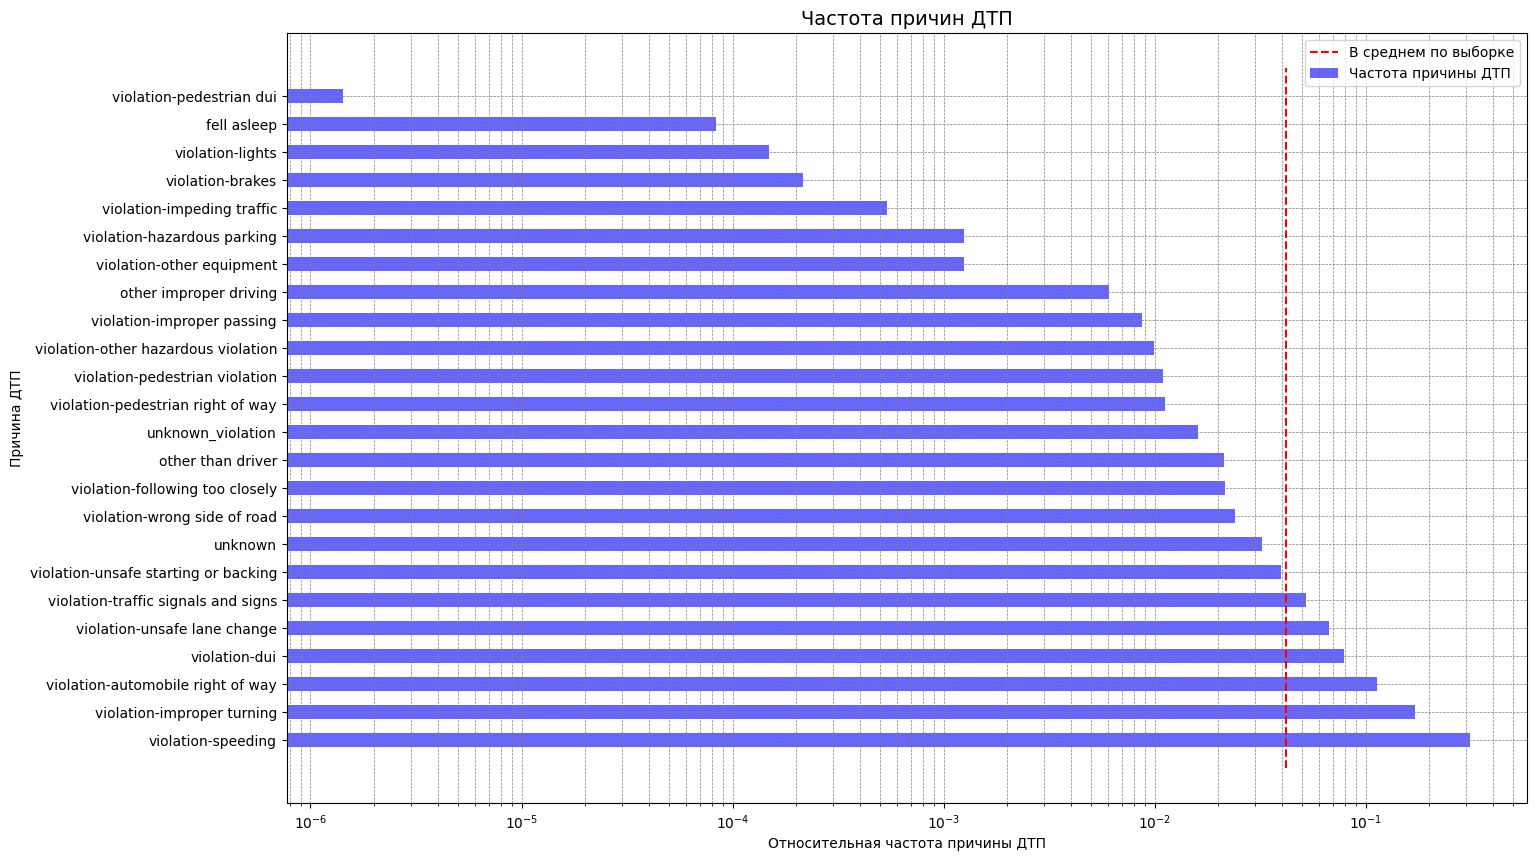

In [23]:
# Построим график для визуализации данных
plt.figure(figsize=(16,10))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
plt.title('Частота причин ДТП', fontsize=14)
plt.xscale('log')
y_axe = range(1, factors.shape[0]+1)
plt.xticks(rotation=0)
plt.yticks(y_axe, labels=factors['factor'])
plt.xlabel('Относительная частота причины ДТП')
plt.ylabel('Причина ДТП')
plt.barh(y=y_axe, width=factors['relative_frequency'], height=0.5, color='blue',
         label='Частота причины ДТП', alpha=0.6)
plt.plot([factors['relative_frequency'].mean(), factors['relative_frequency'].mean()],
         [0, factors.shape[0]+1], linestyle='--', color='red', label='В среднем по выборке')
plt.legend()
plt.show()

Вывод.

Наиболее частыми причинами ДТП стали:
- нарушение скорости,
- неправильный поворот,
- несоблюдение приоритета проезда транспортных средств,
- dui (вождение в нетрезвом состоянии),
- небезопасное перестроение,
- несоблюдение требований дорожных сигналов и знаков.

Исходя из вышеизложенного можем заключить, что большинство ДТП связано с человеческим фактором и различными нарушениями.

###  Повреждения и состояние участника ДТП

####  Повреждения и состояние виновника

Выясним, как связаны между собой состояние виновника ДТП в момент аварии и серьёзность повреждений, а также как отличается состояние виновников ДТП и других участников аварий. Будем определять относительную частоту той или иной серьёзности повреждений при различных состояниях виновника ДТП, а также относительное количество виновников и других участников с тем или иным состоянием.

In [24]:
# Выберем требуемые данные по виновникам и тяжести повреждений
query = '''
SELECT sobriety,
       drug_physical,
       damage,
       fault,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault, sobriety, drug_physical) AS relative_frequency,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault) AS total_frequency
FROM   (SELECT p.party_sobriety AS sobriety,
               p.party_drug_physical AS drug_physical,
               c.collision_damage AS damage,
               p.at_fault AS fault,
               COUNT(*) AS col_cnt
        FROM parties AS p
        JOIN collisions AS c ON p.case_id = c.case_id
        GROUP BY sobriety, drug_physical, damage, fault
        ORDER BY sobriety, drug_physical, damage, fault) AS dmg_cnt
ORDER BY fault, sobriety, drug_physical, damage
'''
parties_data = pd.read_sql_query(query, con=engine)
parties_data

sobriety          drug_physical  \
0    had been drinking, impairment unknown  impairment - physical   
1    had been drinking, impairment unknown   under drug influence   
2    had been drinking, impairment unknown   under drug influence   
3    had been drinking, impairment unknown                   None   
4    had been drinking, impairment unknown                   None   
..                                     ...                    ...   
188                                   None                   None   
189                                   None                   None   
190                                   None                   None   
191                                   None                   None   
192                                   None                   None   

            damage  fault  relative_frequency  total_frequency  
0     small damage      0            1.000000     6.829290e-07  
1            fatal      0            0.954545     1.434151e-05  
2     small damage      0            0.045455     6.829290e-07  
3            fatal      0            0.022099     6.556119e-05  
4    middle damage      0            0.142495     4.227331e-04  
..             ...    ...                 ...              ...  
188          fatal      1            0.002219     2.173699e-05  
189  middle damage      1            0.107483     1.052691e-03  
190        scratch      1            0.228916     2.242015e-03  
191  severe damage      1            0.021401     2.096067e-04  
192   small damage      1            0.639981     6.268015e-03  

[193 rows x 6 columns]

In [25]:
# Заполним пропуски заглушкой
parties_data['sobriety'] = parties_data['sobriety'].fillna('filled_NA')
parties_data['drug_physical'] = parties_data['drug_physical'].fillna('filled_NA')
# Рассмотрим, какие категории состояния можно выделить
parties_data['condition'] = parties_data['sobriety'] + '-' + parties_data['drug_physical']
parties_data['condition'].value_counts(dropna=False)

condition
had not been drinking-impairment - physical                     10
had been drinking, under influence-under drug influence         10
filled_NA-impairment - physical                                 10
not applicable-not applicable                                   10
impairment unknown-G                                            10
had not been drinking-filled_NA                                 10
had not been drinking-sleepy/fatigued                           10
filled_NA-filled_NA                                             10
had been drinking, under influence-filled_NA                    10
had been drinking, not under influence-filled_NA                10
had been drinking, impairment unknown-filled_NA                 10
filled_NA-under drug influence                                  10
had been drinking, under influence-sleepy/fatigued               9
had not been drinking-under drug influence                       9
filled_NA-sleepy/fatigued                           

In [26]:
# Изменим наименования категорий
replace_map = {'had been drinking, impairment unknown-impairment - physical':'пил (влияние не известно)-ухудшение состояния',
       'had been drinking, impairment unknown-sleepy/fatigued':'пил (влияние не известно)-сонный, уставший',
       'had been drinking, impairment unknown-under drug influence':'пил (влияние не известно)-под действием лекарств',
       'had been drinking, impairment unknown-filled_NA':'пил (влияние не известно)',
       'had been drinking, not under influence-impairment - physical':'пил (не под влиянием)-ухудшение состояния',
       'had been drinking, not under influence-sleepy/fatigued':'пил (не под влиянием)-сонный, уставший',
       'had been drinking, not under influence-under drug influence':'пил (не под влиянием)-под действием лекарств',
       'had been drinking, not under influence-filled_NA':'пил (не под влиянием)',
       'had been drinking, under influence-impairment - physical':'пил (под влиянием)-ухудшение состояния',
       'had been drinking, under influence-sleepy/fatigued':'пил (под влиянием)-сонный, уставший',
       'had been drinking, under influence-under drug influence':'пил (под влиянием)-под действием лекарств',
       'had been drinking, under influence-filled_NA':'пил (под влиянием)',
       'had not been drinking-impairment - physical':'не пил-ухудшение состояния',
       'had not been drinking-sleepy/fatigued':'не пил-сонный, уставший',
       'had not been drinking-under drug influence':'не пил-под действием лекарств',
       'had not been drinking-filled_NA':'не пил',
       'impairment unknown-G':'no info',
       'not applicable-not applicable':'не оценивался',
       'filled_NA-impairment - physical':'ухудшение состояния',
       'filled_NA-sleepy/fatigued':'сонный, уставший',
       'filled_NA-under drug influence':'под действием лекарств',
       'filled_NA-filled_NA':'no info 1'
}
parties_data['condition'] = parties_data['condition'].replace(replace_map)
parties_data['condition'].value_counts(dropna=False)

condition
не пил-ухудшение состояния                          10
пил (под влиянием)-под действием лекарств           10
ухудшение состояния                                 10
не оценивался                                       10
no info                                             10
не пил                                              10
не пил-сонный, уставший                             10
no info 1                                           10
пил (под влиянием)                                  10
пил (не под влиянием)                               10
пил (влияние не известно)                           10
под действием лекарств                              10
пил (под влиянием)-сонный, уставший                  9
не пил-под действием лекарств                        9
сонный, уставший                                     9
пил (под влиянием)-ухудшение состояния               8
пил (не под влиянием)-под действием лекарств         8
пил (не под влиянием)-сонный, уставший               8


In [27]:
# Объединим строки с отсутствующими данными и уберём лишние столбцы и строки
parties_data = parties_data.drop(['sobriety', 'drug_physical'], axis=1)
for fault in [0, 1]:
    for dam in parties_data['damage'].unique():
        parties_data.loc[(parties_data['condition']=='no info')&
                         (parties_data['damage']==dam)&
                         (parties_data['fault']==fault),
                         'relative_frequency']  = \
        (parties_data.loc[(parties_data['condition']=='no info')&
                         (parties_data['damage']==dam)&
                         (parties_data['fault']==fault),
                         'relative_frequency'].values[0] + \
        parties_data.loc[(parties_data['condition']=='no info 1')&
                         (parties_data['damage']==dam)&
                         (parties_data['fault']==fault),
                         'relative_frequency'].values[0])*0.5
        parties_data.loc[(parties_data['condition']=='no info')&
                         (parties_data['damage']==dam)&
                         (parties_data['fault']==fault),
                         'total_frequency']  = \
        parties_data.loc[(parties_data['condition']=='no info')&
                         (parties_data['damage']==dam)&
                         (parties_data['fault']==fault),
                         'total_frequency'].values[0] + \
        parties_data.loc[(parties_data['condition']=='no info 1')&
                         (parties_data['damage']==dam)&
                         (parties_data['fault']==fault),
                         'total_frequency'].values[0]
    parties_data = parties_data.loc[~((parties_data['condition']=='no info 1')&
                                    (parties_data['fault']==fault))]
parties_data

damage  fault  relative_frequency  total_frequency  \
0     small damage      0            1.000000     6.829290e-07   
1            fatal      0            0.954545     1.434151e-05   
2     small damage      0            0.045455     6.829290e-07   
3            fatal      0            0.022099     6.556119e-05   
4    middle damage      0            0.142495     4.227331e-04   
..             ...    ...                 ...              ...   
183          fatal      1            0.032397     2.274620e-04   
184  middle damage      1            0.154578     1.085297e-03   
185        scratch      1            0.202897     1.424549e-03   
186  severe damage      1            0.048430     3.400286e-04   
187   small damage      1            0.561698     3.943711e-03   

                                            condition  
0       пил (влияние не известно)-ухудшение состояния  
1    пил (влияние не известно)-под действием лекарств  
2    пил (влияние не известно)-под действием лекарств  
3                           пил (влияние не известно)  
4                           пил (влияние не известно)  
..                                                ...  
183                            под действием лекарств  
184                            под действием лекарств  
185                            под действием лекарств  
186                            под действием лекарств  
187                            под действием лекарств  

[183 rows x 5 columns]

In [28]:
# Агрегируем данные по состоянию виновника в сводную таблицу
parties_data_f_g = parties_data[parties_data['fault']==1].pivot_table(values=['relative_frequency'], index=['condition'],
                              columns=['damage'], aggfunc='first')
parties_data_f_g.columns = parties_data_f_g.columns.droplevel()
parties_data_f = parties_data_f_g.merge(parties_data[parties_data['fault']==1].pivot_table(values=['total_frequency'],
                                        index=['condition'], aggfunc='sum'),
                             left_index=True, right_index=True)
parties_data_f = parties_data_f.fillna(0)
parties_data_f = parties_data_f.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                      ascending=True)
parties_data_f

fatal  middle damage  \
condition                                                                   
пил (не под влиянием)-ухудшение состояния         0.000000       0.187500   
пил (влияние не известно)-ухудшение состояния     0.000000       0.000000   
не оценивался                                     0.001328       0.104367   
сонный, уставший                                  0.003147       0.173807   
no info                                           0.004005       0.080002   
не пил                                            0.004400       0.123978   
ухудшение состояния                               0.007529       0.164956   
пил (не под влиянием)                             0.012512       0.183161   
пил (влияние не известно)                         0.013118       0.110880   
не пил-сонный, уставший                           0.015502       0.174626   
пил (под влиянием)                                0.021351       0.198902   
пил (не под влиянием)-сонный, уставший            0.021875       0.231250   
пил (влияние не известно)-сонный, уставший        0.022727       0.272727   
пил (под влиянием)-сонный, уставший               0.026954       0.242588   
под действием лекарств                            0.032397       0.154578   
не пил-ухудшение состояния                        0.042614       0.207386   
пил (под влиянием)-ухудшение состояния            0.055556       0.166667   
пил (под влиянием)-под действием лекарств         0.540881       0.094340   
пил (не под влиянием)-под действием лекарств      0.565657       0.080808   
пил (влияние не известно)-под действием лекарств  0.638158       0.085526   
не пил-под действием лекарств                     0.765443       0.046553   

                                                   scratch  severe damage  \
condition                                                                   
пил (не под влиянием)-ухудшение состояния         0.312500       0.000000   
пил (влияние не известно)-ухудшение состояния     0.333333       0.333333   
не оценивался                                     0.255761       0.017186   
сонный, уставший                                  0.237454       0.024830   
no info                                           0.179942       0.018705   
не пил                                            0.291937       0.019017   
ухудшение состояния                               0.264887       0.024641   
пил (не под влиянием)                             0.229386       0.037449   
пил (влияние не известно)                         0.128747       0.050929   
не пил-сонный, уставший                           0.221311       0.035638   
пил (под влиянием)                                0.145062       0.053541   
пил (не под влиянием)-сонный, уставший            0.156250       0.034375   
пил (влияние не известно)-сонный, уставший        0.227273       0.045455   
пил (под влиянием)-сонный, уставший               0.159030       0.040431   
под действием лекарств                            0.202897       0.048430   
не пил-ухудшение состояния                        0.244318       0.031250   
пил (под влиянием)-ухудшение состояния            0.055556       0.083333   
пил (под влиянием)-под действием лекарств         0.073185       0.035449   
пил (не под влиянием)-под действием лекарств      0.070707       0.030303   
пил (влияние не известно)-под действием лекарств  0.078947       0.078947   
не пил-под действием лекарств                     0.042972       0.014324   

                                                  small damage  \
condition                                                        
пил (не под влиянием)-ухудшение состояния             0.500000   
пил (влияние не известно)-ухудшение состояния         0.333333   
не оценивался                                         0.621358   
сонный, уставший                                      0.560762   
no info                                               0.717347   
не пил                                         

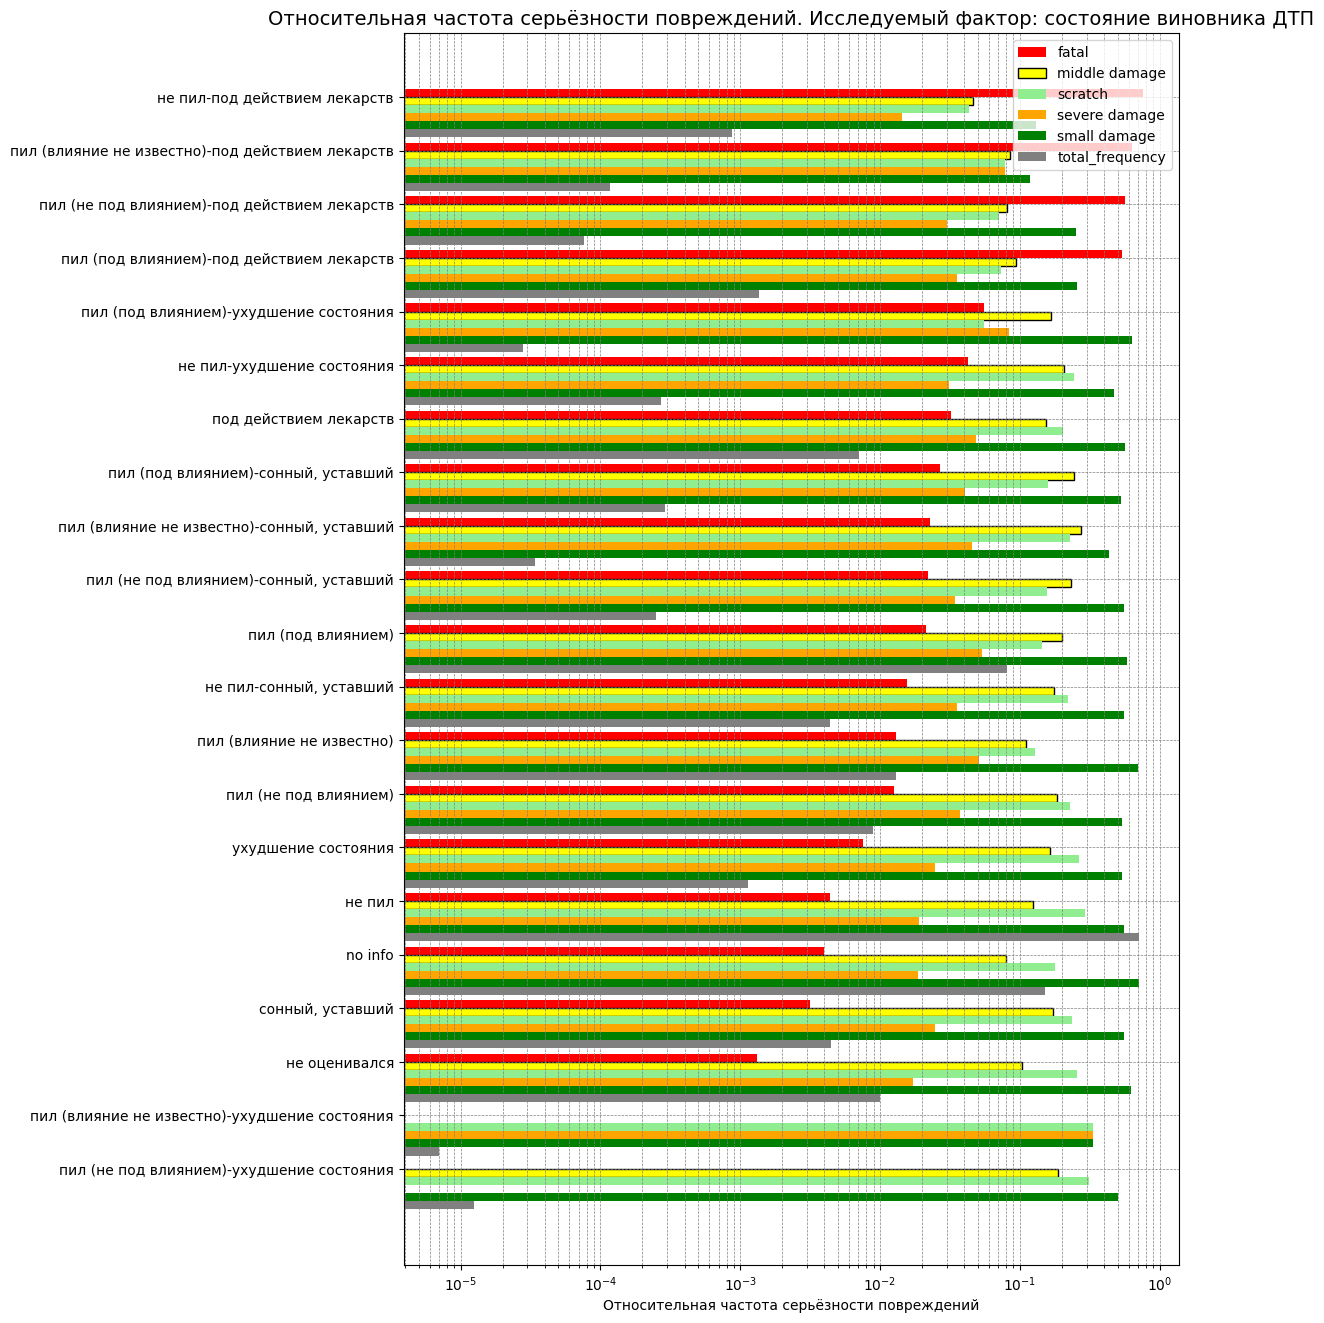

In [29]:
# Посмотрим, как распределена частотность серьёзности повреждений
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(10, 16),
                       sharex=False)
# В зависимости от состояния виновника ДТП
data = parties_data_f
factor = 'состояние виновника ДТП'
rotation = 0
vert = False
factors_of_damage_show(data, factor, ax, rotation, vert)
plt.show()

Выводы.
Наибольшая частота ДТП с самыми тяжёлыми последствиями (fatal, не подлежит восстановлению) наблюдается в случаях, когда виновник ДТП:
- был под влиянием выпитого алкоголя,
- был под влиянием лекарств,
- был под влиянием выпитого алкоголя и принятых лекарств.

Наибольшая частота ДТП с тяжёлыми последствиями (severe, серьёзный ремонт, большая часть под замену/серьёзное повреждение капитального строения), со средними повреждениями (middle, средний ремонт, машина в целом на ходу/Строение в целом устояло), с незначительными повреждениями (small, отдельный элемент кузова под замену/покраску) и с последствиями в виде царапин наблюдается в случаях, когда виновник ДТП:
- пил алкоголь (независимо от того, был под влиянием или нет),
- был под влиянием лекарств,
- был сонным или уставшим.

Больше всего ДТП зафиксировано, когда виновник не пил (информации о состоянии нет), пил (независимо от влияния), находился под действием лекарств, был сонный или уставший.

Исходя из вышеизложенного можем заключить, что тяжесть ДТП зависит от того, употреблял ли водитель алкоголь, лекарства, а также от того, насколько выспавшимся и отдохнувшим он был.

####  Состояние виновника и остальных участников ДТП

In [30]:
# Агрегируем данные для сравнения автомобилей виновника и других участников ДТП в сводную таблицу
parties_data = parties_data.pivot_table(values=['total_frequency'], index=['condition'],
                                        columns=['fault'], aggfunc='sum')
parties_data.columns = parties_data.columns.droplevel()
parties_data.columns = ['участник', 'виновник']
# заполним пропуски и отсортируем данные в столбцах
parties_data = parties_data.fillna(0)
parties_data['delta'] = parties_data['виновник'] - parties_data['участник']
parties_data = parties_data.sort_values(by=['delta'], ascending=True)
parties_data = parties_data.drop(['delta'], axis=1)
parties_data

участник  виновник
condition                                                               
не пил                                            8.159759e-01  0.715565
не оценивался                                     1.069071e-01  0.009938
ухудшение состояния                               1.223126e-03  0.001134
не пил-ухудшение состояния                        3.435133e-04  0.000273
пил (не под влиянием)-ухудшение состояния         9.561006e-06  0.000012
пил (влияние не известно)-ухудшение состояния     6.829290e-07  0.000007
пил (под влиянием)-ухудшение состояния            3.414645e-06  0.000028
пил (влияние не известно)-сонный, уставший        0.000000e+00  0.000034
пил (не под влиянием)-под действием лекарств      2.048787e-05  0.000077
пил (влияние не известно)-под действием лекарств  1.502444e-05  0.000118
пил (не под влиянием)-сонный, уставший            9.561006e-06  0.000248
пил (под влиянием)-сонный, уставший               1.092686e-05  0.000288
не пил-под действием лекарств                     2.533667e-04  0.000867
пил (под влиянием)-под действием лекарств         1.079028e-04  0.001358
не пил-сонный, уставший                           1.468297e-04  0.004357
сонный, уставший                                  2.253666e-04  0.004440
пил (не под влиянием)                             3.857183e-03  0.008935
под действием лекарств                            3.230254e-04  0.007021
пил (влияние не известно)                         2.966644e-03  0.013079
пил (под влиянием)                                4.294258e-03  0.080574
no info                                           6.330616e-02  0.151647

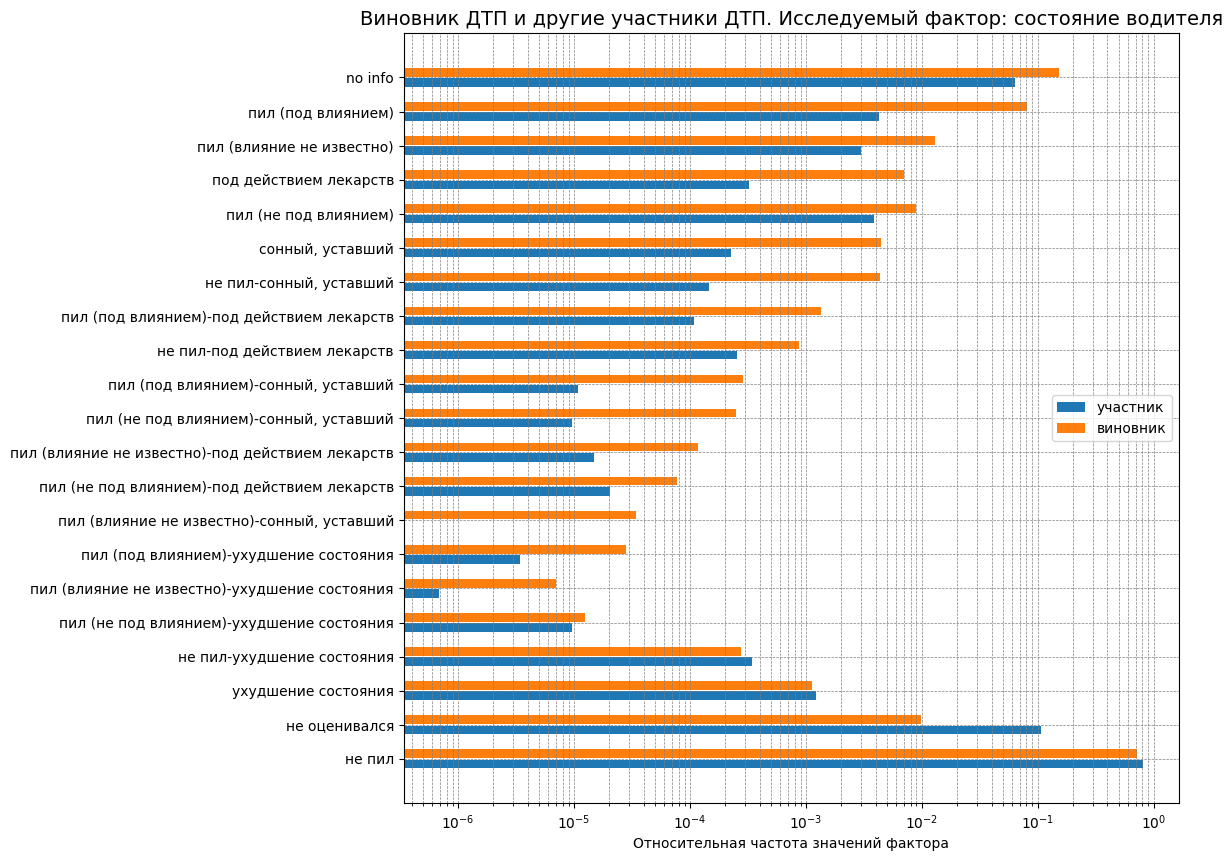

In [31]:
# Посмотрим, как распределена частотность состояний участников ДТП
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(10, 10),
                       sharex=False)
data = parties_data
factor = 'состояние водителя'
rotation = 0
vert = False
fault_and_others_show(data, factor, ax, rotation, vert)
plt.show()

Доля таких состояний, как: пил (независимо от влияния), под действием лекарств, сонный/уставший выше у виновников ДТП, чем у других участников ДТП.

###  Повреждения и транспортное средство

Выясним, как связаны между собой автомобиль виновника ДТП и серьёзность повреждений, а также как отличаются автомобили виновников ДТП и других участников аварий.

####  Тип транспортного средства

In [32]:
# Выберем требуемые данные по типам автомобиля
query = '''
SELECT type,
       damage,
       fault,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault, type) AS relative_frequency,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault) AS total_frequency
FROM   (SELECT v.vehicle_type AS type,
               c.collision_damage AS damage,
               p.at_fault AS fault,
               COUNT(*) AS col_cnt
        FROM vehicles AS v
        JOIN parties AS p ON v.case_id = p.case_id AND v.party_number = p.party_number
        JOIN collisions AS c ON p.case_id = c.case_id
        GROUP BY type, damage, fault
        ORDER BY type, damage, fault) AS type_cnt
ORDER BY fault, type, damage
'''
type_data = pd.read_sql_query(query, con=engine)
type_data

type         damage  fault  relative_frequency  total_frequency
0       coupe          fatal      0            0.012718         0.005351
1       coupe  middle damage      0            0.216594         0.091129
2       coupe        scratch      0            0.734757         0.309138
3       coupe  severe damage      0            0.035931         0.015118
4   hatchback          fatal      0            0.041928         0.002288
5   hatchback  middle damage      0            0.365919         0.019970
6   hatchback        scratch      0            0.483408         0.026382
7   hatchback  severe damage      0            0.108744         0.005935
8     minivan          fatal      0            0.011225         0.000372
9     minivan  middle damage      0            0.515968         0.017116
10    minivan        scratch      0            0.404247         0.013410
11    minivan  severe damage      0            0.068560         0.002274
12      other          fatal      0            0.019560         0.000028
13      other  middle damage      0            0.330073         0.000472
14      other        scratch      0            0.548900         0.000785
15      other  severe damage      0            0.101467         0.000145
16      sedan          fatal      0            0.005604         0.002746
17      sedan  middle damage      0            0.097281         0.047676
18      sedan        scratch      0            0.310647         0.152244
19      sedan  severe damage      0            0.015138         0.007419
20      sedan   small damage      0            0.571331         0.280002
21      coupe          fatal      1            0.028971         0.013035
22      coupe  middle damage      1            0.392659         0.176667
23      coupe        scratch      1            0.503362         0.226475
24      coupe  severe damage      1            0.075008         0.033748
25  hatchback          fatal      1            0.102748         0.003288
26  hatchback  middle damage      1            0.427965         0.013696
27  hatchback        scratch      1            0.296557         0.009491
28  hatchback  severe damage      1            0.172730         0.005528
29    minivan          fatal      1            0.013070         0.000699
30    minivan  middle damage      1            0.510115         0.027283
31    minivan        scratch      1            0.401349         0.021466
32    minivan  severe damage      1            0.075466         0.004036
33      other          fatal      1            0.015957         0.000013
34      other  middle damage      1            0.441489         0.000370
35      other        scratch      1            0.430851         0.000361
36      other  severe damage      1            0.111702         0.000094
37      sedan          fatal      1            0.006341         0.002941
38      sedan  middle damage      1            0.109000         0.050549
39      sedan        scratch      1            0.274196         0.127159
40      sedan  severe damage      1            0.018856         0.008745
41      sedan   small damage      1            0.591606         0.274359

In [33]:
# Агрегируем данные по автомобилю виновника в сводную таблицу
type_data_f_g = type_data[type_data['fault']==1].pivot_table(values=['relative_frequency'], index=['type'],
                           columns=['damage'], aggfunc='first')
type_data_f_g.columns = type_data_f_g.columns.droplevel()
type_data_f = type_data_f_g.merge(type_data[type_data['fault']==1].pivot_table(values=['total_frequency'],
                                  index=['type'],aggfunc='sum'),
                             left_index=True, right_index=True)
type_data_f = type_data_f.fillna(0)
type_data_f = type_data_f.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                      ascending=False)
type_data_f

fatal  middle damage   scratch  severe damage  small damage  \
type                                                                        
hatchback  0.102748       0.427965  0.296557       0.172730      0.000000   
coupe      0.028971       0.392659  0.503362       0.075008      0.000000   
other      0.015957       0.441489  0.430851       0.111702      0.000000   
minivan    0.013070       0.510115  0.401349       0.075466      0.000000   
sedan      0.006341       0.109000  0.274196       0.018856      0.591606   

           total_frequency  
type                        
hatchback         0.032002  
coupe             0.449924  
other             0.000837  
minivan           0.053484  
sedan             0.463753

In [34]:
# Агрегируем данные для сравнения автомобилей виновника и других участников ДТП в сводную таблицу
type_data = type_data.pivot_table(values=['total_frequency'], index=['type'],
                                  columns=['fault'], aggfunc='sum')
type_data.columns = type_data.columns.droplevel()
type_data.columns = ['участник', 'виновник']
# заполним пропуски и отсортируем данные в столбцах
type_data = type_data.fillna(0)
type_data['delta'] = type_data['виновник'] - type_data['участник']
type_data = type_data.sort_values(by=['delta'], ascending=False)
type_data = type_data.drop(['delta'], axis=1)
type_data

участник  виновник
type                         
coupe      0.420735  0.449924
minivan    0.033172  0.053484
other      0.001430  0.000837
hatchback  0.054576  0.032002
sedan      0.490087  0.463753

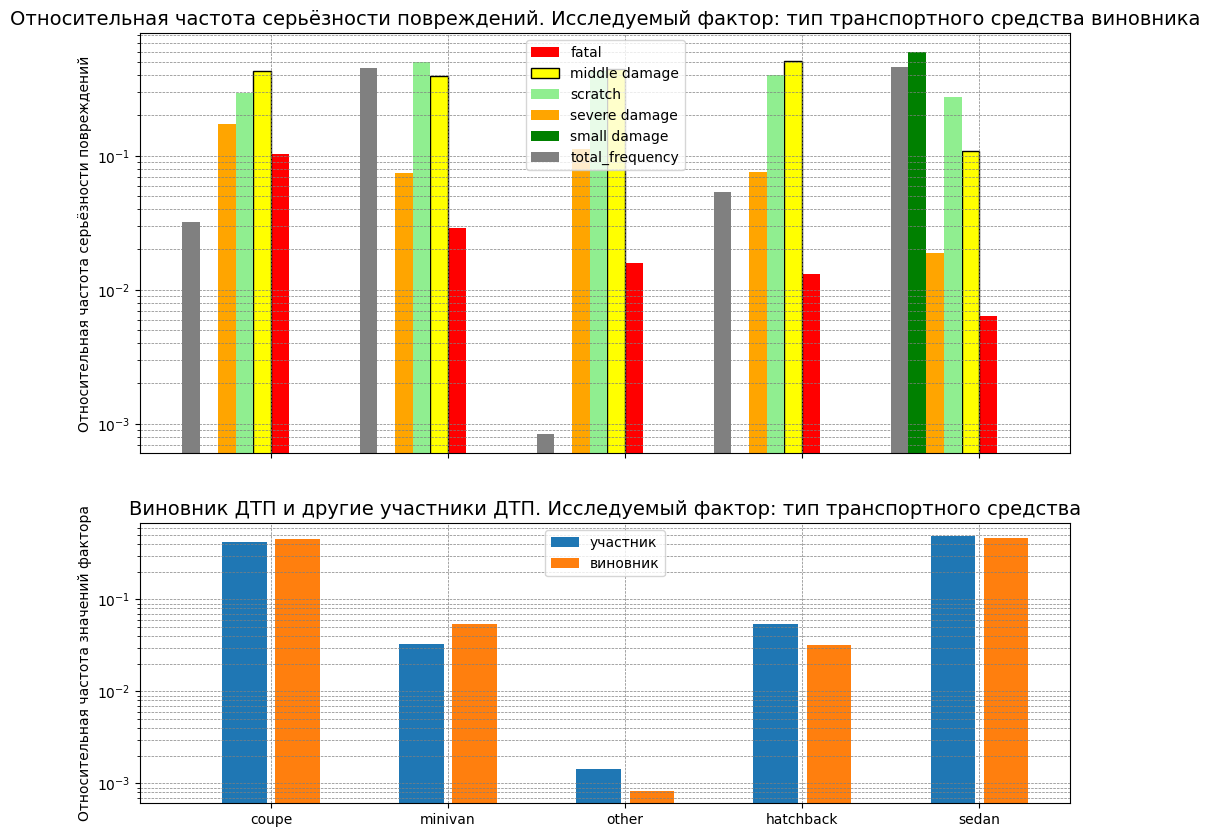

In [35]:
# Построим графики
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(12, 10),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.6, .4)})

# Тяжесть в зависимости от типа транспортного средства виновника
data = type_data_f
factor = 'тип транспортного средства виновника'
rotation = 0
vert = True
factors_of_damage_show(data, factor, ax[0], rotation, vert)
# Посмотрим, какие типы транспортных средств чаще у виновников и у других участников ДТП
data = type_data
factor = 'тип транспортного средства'
rotation = 0
fault_and_others_show(data, factor, ax[1], rotation, vert)
plt.show()

Выводы:
- наибольшая частота ДТП с самыми тяжёлыми последствиями (fatal, не подлежит восстановлению), с тяжёлыми последствиями (severe, серьёзный ремонт, большая часть под замену/серьёзное повреждение капитального строения) наблюдается в случаях, когда виновник на автомобиле типа coupe,
- на втором месте по повреждениям типа fatal, severe - автомобиль типа minivan и hatchback,
- со средними повреждениями (middle, средний ремонт, машина в целом на ходу/Строение в целом устояло) наиболее часто ДТП наблюдаются, когда виновник за рулём hatchback, на втором месте - coupe,
- царапины встречаются одинаково часто по всем типам авто,
- виновники ДТП чаще за рулём автомобилей coupe и minivan,
- большинство ДТП происходит с автомобилями sedan и minivan.

Исходя из вышеизложенного можем заключить, что наибольшая частота серьёзных повреждений наблюдается по вине водителей автомобилей типа coupe, minivan, hatchback.

####  Тип коробки передач

In [36]:
# Выберем требуемые данные по типy коробки передач
query = '''
SELECT transmission,
       damage,
       fault,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault, transmission) AS relative_frequency,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault) AS total_frequency
FROM   (SELECT v.vehicle_transmission AS transmission,
               c.collision_damage AS damage,
               p.at_fault AS fault,
               COUNT(*) AS col_cnt
        FROM vehicles AS v
        JOIN parties AS p ON v.case_id = p.case_id AND v.party_number = p.party_number
        JOIN collisions AS c ON p.case_id = c.case_id
        GROUP BY transmission, damage, fault
        ORDER BY transmission, damage, fault) AS transmission_cnt
ORDER BY fault, transmission, damage
'''
transmission_data = pd.read_sql_query(query, con=engine)
transmission_data

transmission         damage  fault  relative_frequency  total_frequency
0          auto          fatal      0            0.007580         0.003980
1          auto  middle damage      0            0.146759         0.077063
2          auto        scratch      0            0.532089         0.279401
3          auto  severe damage      0            0.022698         0.011919
4          auto   small damage      0            0.290874         0.152739
5        manual          fatal      0            0.014997         0.006758
6        manual  middle damage      0            0.210468         0.094842
7        manual        scratch      0            0.460850         0.207669
8        manual  severe damage      0            0.040422         0.018215
9        manual   small damage      0            0.273262         0.123138
10         None          fatal      0            0.001944         0.000047
11         None  middle damage      0            0.183625         0.004458
12         None        scratch      0            0.613307         0.014889
13         None  severe damage      0            0.031180         0.000757
14         None   small damage      0            0.169943         0.004126
15         auto          fatal      1            0.011493         0.005165
16         auto  middle damage      1            0.220550         0.099113
17         auto        scratch      1            0.441372         0.198348
18         auto  severe damage      1            0.034975         0.015717
19         auto   small damage      1            0.291609         0.131046
20       manual          fatal      1            0.027905         0.014758
21       manual  middle damage      1            0.309589         0.163728
22       manual        scratch      1            0.331626         0.175382
23       manual  severe damage      1            0.067075         0.035473
24       manual   small damage      1            0.263805         0.139515
25         None          fatal      1            0.002456         0.000053
26         None  middle damage      1            0.263099         0.005724
27         None        scratch      1            0.515759         0.011220
28         None  severe damage      1            0.044106         0.000960
29         None   small damage      1            0.174580         0.003798

In [37]:
# Заполним пропуски заглушкой
transmission_data['transmission'] = transmission_data['transmission'].fillna('unknown')
# Агрегируем данные в сводную таблицу
transmission_data_f_g = transmission_data[transmission_data['fault']==1].pivot_table(values=['relative_frequency'],
                                                                                   index=['transmission'],
                                                                                   columns=['damage'], aggfunc='first')
transmission_data_f_g.columns = transmission_data_f_g.columns.droplevel()
transmission_data_f = transmission_data_f_g.merge(transmission_data[transmission_data['fault']==1]. \
                                                  pivot_table(values=['total_frequency'],
                                                  index=['transmission'],aggfunc='sum'),
                                                   left_index=True, right_index=True)
transmission_data_f = transmission_data_f.fillna(0)
transmission_data_f = transmission_data_f.sort_values(
                     by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                     ascending=False)
transmission_data_f

fatal  middle damage   scratch  severe damage  small damage  \
transmission                                                                   
manual        0.027905       0.309589  0.331626       0.067075      0.263805   
auto          0.011493       0.220550  0.441372       0.034975      0.291609   
unknown       0.002456       0.263099  0.515759       0.044106      0.174580   

              total_frequency  
transmission                   
manual               0.528856  
auto                 0.449389  
unknown              0.021755

In [38]:
# Агрегируем данные для сравнения автомобилей виновника и других участников ДТП в сводную таблицу
transmission_data = transmission_data.pivot_table(values=['total_frequency'], index=['transmission'],
                                                  columns=['fault'], aggfunc='sum')
transmission_data.columns = transmission_data.columns.droplevel()
transmission_data.columns = ['участник', 'виновник']
# заполним пропуски и отсортируем данные в столбцах
transmission_data = transmission_data.fillna(0)
transmission_data['delta'] = transmission_data['виновник'] - transmission_data['участник']
transmission_data = transmission_data.sort_values(by=['delta'], ascending=False)
transmission_data = transmission_data.drop(['delta'], axis=1)
transmission_data

участник  виновник
transmission                    
manual        0.450622  0.528856
unknown       0.024276  0.021755
auto          0.525102  0.449389

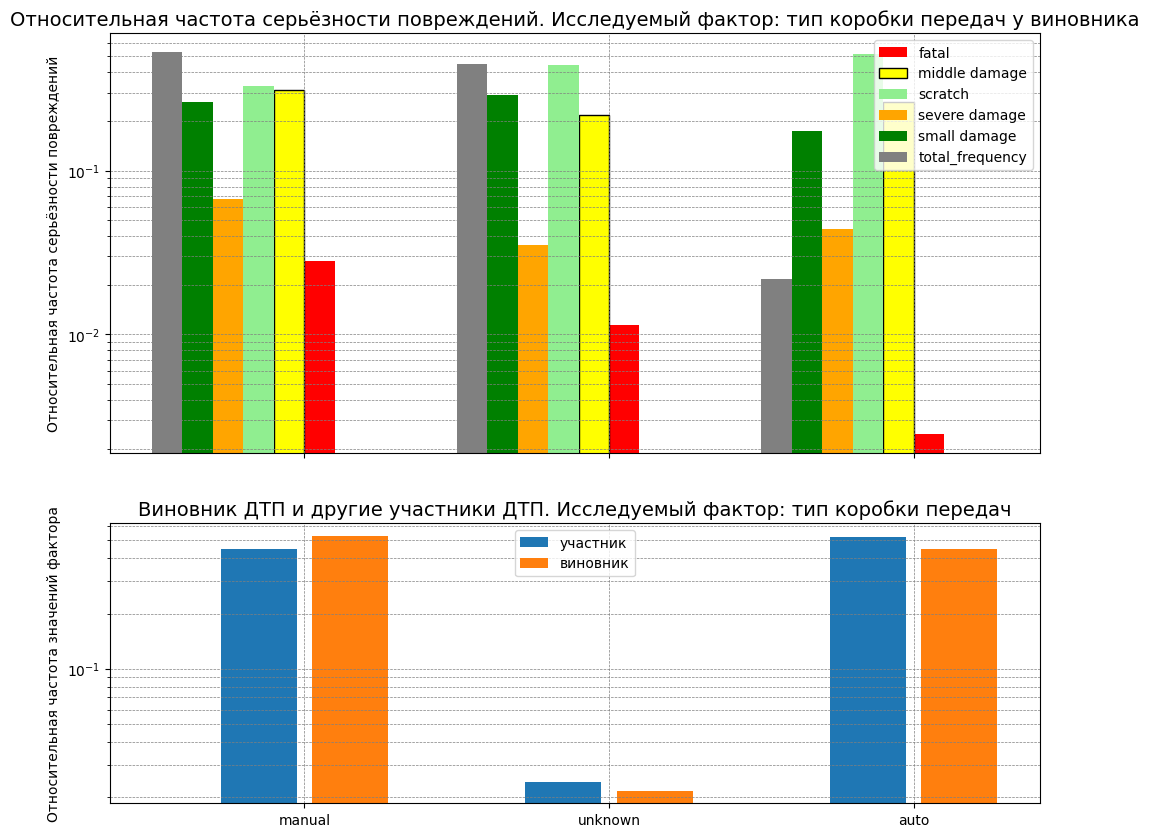

In [39]:
# Построим графики
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(12, 10),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.6, .4)})
# Тяжесть в зависимости от типа коробки передач у виновника
data = transmission_data_f
factor = 'тип коробки передач у виновника'
rotation = 0
vert = True
factors_of_damage_show(data, factor, ax[0], rotation, vert)
# Посмотрим, какие типы коробки передач чаще у виновников и у других участников ДТП
data = transmission_data
factor = 'тип коробки передач'
fault_and_others_show(data, factor, ax[1], rotation, vert)
plt.show()

По диаграммам можем заключить, что наибольшая частота всех ДТП наблюдается по вине водителей автомобилей с механической коробкой.

####  Возраст транспортного средства

In [40]:
# Выберем требуемые данные по возрасту транспортных средств
query = '''
SELECT CAST(age AS integer) AS age,
       damage,
       fault,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault, age) AS relative_frequency,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault) AS total_frequency
FROM   (SELECT v.vehicle_age AS age,
               c.collision_damage AS damage,
               p.at_fault AS fault,
               COUNT(*) AS col_cnt
        FROM vehicles AS v
        JOIN parties AS p ON v.case_id = p.case_id AND v.party_number = p.party_number
        JOIN collisions AS c ON p.case_id = c.case_id
        GROUP BY age, damage, fault
        ORDER BY age, damage, fault) AS type_cnt
ORDER BY fault, age, damage
'''
age_data = pd.read_sql_query(query, con=engine)
age_data

age         damage  fault  relative_frequency  total_frequency
0    0.0          fatal      0            0.006440         0.000250
1    0.0  middle damage      0            0.141950         0.005510
2    0.0        scratch      0            0.256879         0.009971
3    0.0  severe damage      0            0.018870         0.000732
4    0.0   small damage      0            0.575861         0.022353
..   ...            ...    ...                 ...              ...
189  NaN          fatal      1            0.006012         0.000145
190  NaN  middle damage      1            0.121635         0.002928
191  NaN        scratch      1            0.323652         0.007790
192  NaN  severe damage      1            0.019795         0.000476
193  NaN   small damage      1            0.528906         0.012730

[194 rows x 5 columns]

In [41]:
# Изучим данные по возрасту
age_data['age'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20., 161.,
        nan])

In [42]:
# Посмотрим долю строк с пропусками и со странным значением возраста 161
age_data.loc[(age_data['age']==161)|age_data['age'].isna(), 'total_frequency'].sum()/2

0.024087823101481262

In [43]:
# Избавимся от таких строк и исправим тип данных столбца с возрастом
age_data = age_data.loc[~((age_data['age']==161)|age_data['age'].isna())].copy()
age_data['age'] = age_data['age'].astype('int')

In [44]:
# Агрегируем данные по автомобилю виновника в сводную таблицу
age_data_f_g = age_data[age_data['fault']==1].pivot_table(values=['relative_frequency'], index=['age'],
                                                        columns=['damage'], aggfunc='first')
age_data_f_g.columns = age_data_f_g.columns.droplevel()
age_data_f = age_data_f_g.merge(age_data[age_data['fault']==1].pivot_table(values=['total_frequency'],
                                index=['age'],aggfunc='sum'),
                                left_index=True, right_index=True)
age_data_f = age_data_f.fillna(0)
age_data_f

fatal  middle damage   scratch  severe damage  small damage  \
age                                                                   
0    0.004763       0.155009  0.273246       0.021764      0.545218   
1    0.005286       0.220448  0.315712       0.034171      0.424383   
2    0.009070       0.240355  0.332979       0.037910      0.379685   
3    0.017442       0.285515  0.362307       0.050229      0.284508   
4    0.021071       0.291221  0.386989       0.057613      0.243106   
5    0.021824       0.282802  0.410301       0.060491      0.224582   
6    0.023269       0.280604  0.432949       0.063542      0.199634   
7    0.026493       0.284214  0.434165       0.066383      0.188744   
8    0.029434       0.281436  0.448938       0.069582      0.170610   
9    0.030251       0.292775  0.447577       0.066015      0.163383   
10   0.032048       0.280456  0.452663       0.060668      0.174166   
11   0.032987       0.280529  0.444087       0.053386      0.189010   
12   0.037889       0.297614  0.433116       0.046132      0.185249   
13   0.046917       0.323631  0.404060       0.044619      0.180774   
14   0.049173       0.334823  0.388914       0.053643      0.173447   
15   0.061798       0.345506  0.311798       0.047753      0.233146   
16   0.083333       0.194444  0.416667       0.000000      0.305556   
17   0.000000       0.142857  0.428571       0.000000      0.428571   
19   0.000000       0.666667  0.333333       0.000000      0.000000   

     total_frequency  
age                   
0           0.040199  
1           0.040850  
2           0.129840  
3           0.216735  
4           0.125623  
5           0.091199  
6           0.068215  
7           0.066972  
8           0.060886  
9           0.046437  
10          0.031815  
11          0.024228  
12          0.015395  
13          0.011625  
14          0.004980  
15          0.000793  
16          0.000080  
17          0.000031  
19          0.000007

In [45]:
# Агрегируем данные для сравнения автомобилей виновника и других участников ДТП в сводную таблицу
age_data = age_data.pivot_table(values=['total_frequency'], index=['age'],
                                  columns=['fault'], aggfunc='sum')
age_data.columns = age_data.columns.droplevel()
age_data.columns = ['участник', 'виновник']
# заполним пропуски и отсортируем данные в столбцах
age_data = age_data.fillna(0)
age_data

участник  виновник
age                    
0    0.038817  0.040199
1    0.040133  0.040850
2    0.084273  0.129840
3    0.141939  0.216735
4    0.120696  0.125623
5    0.112001  0.091199
6    0.093910  0.068215
7    0.094745  0.066972
8    0.086917  0.060886
9    0.065372  0.046437
10   0.042245  0.031815
11   0.028305  0.024228
12   0.014041  0.015395
13   0.008573  0.011625
14   0.003250  0.004980
15   0.000554  0.000793
16   0.000105  0.000080
17   0.000030  0.000031
18   0.000002  0.000000
19   0.000005  0.000007
20   0.000003  0.000000

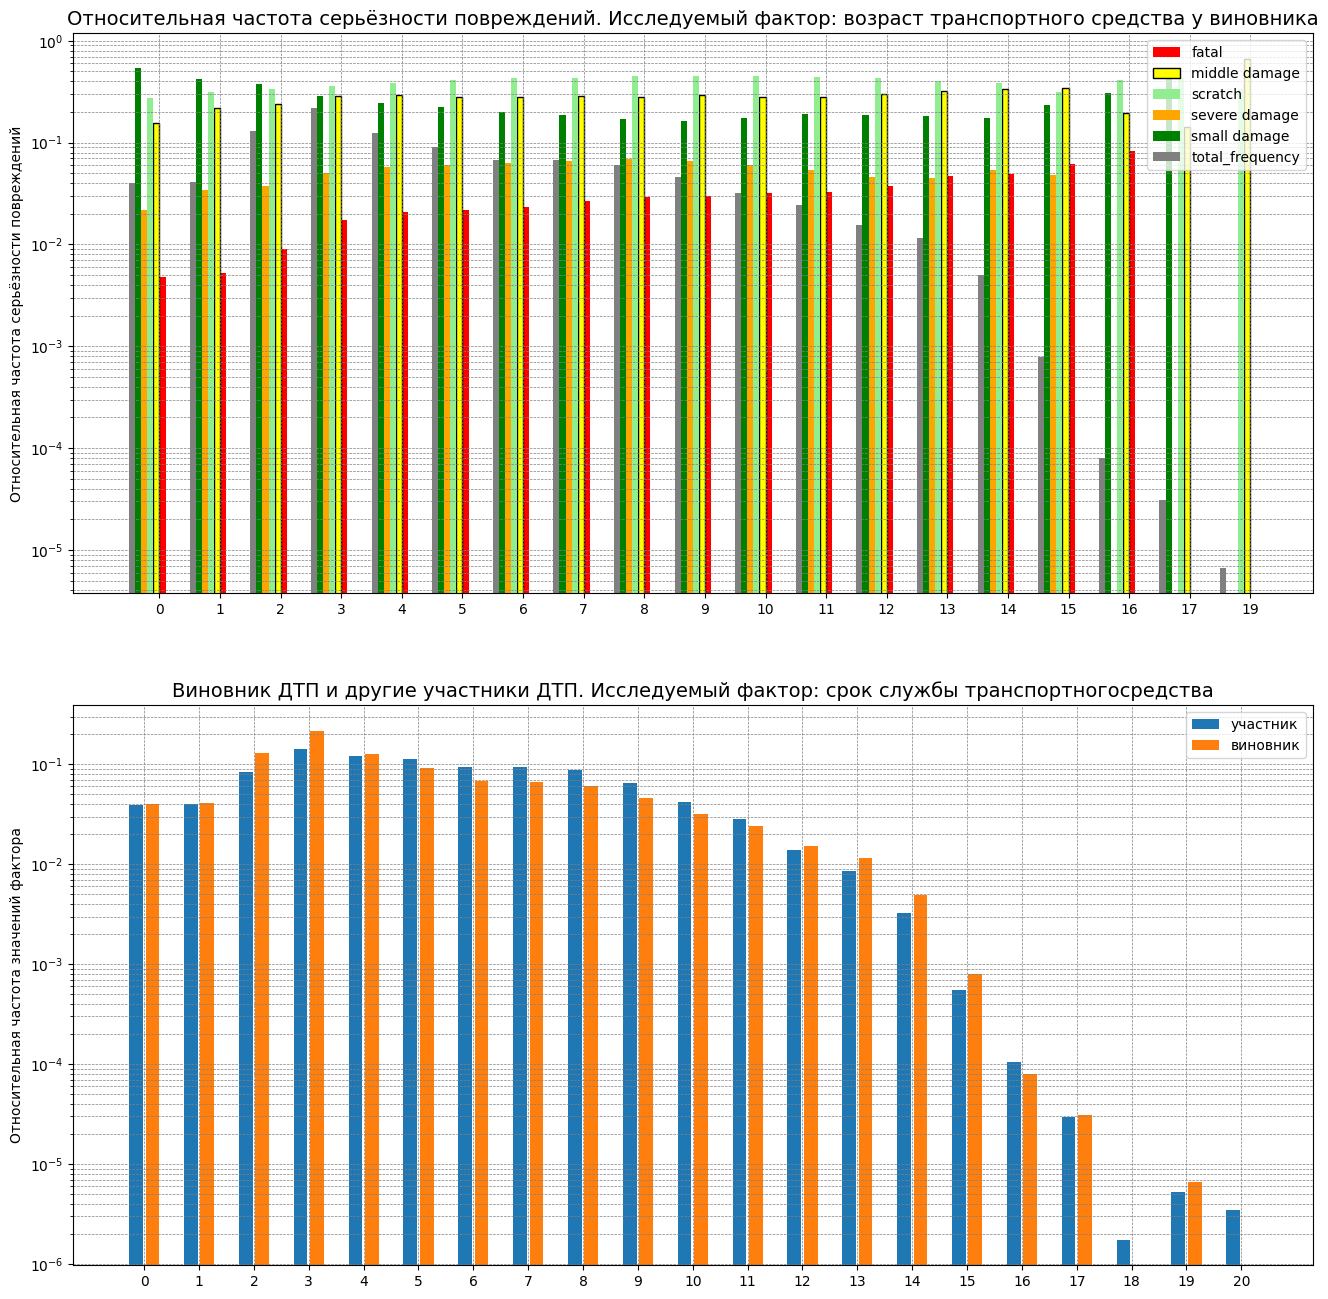

In [46]:
# Построим графики
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(16, 16),
                       sharex=False,
                       gridspec_kw={'height_ratios': (.5, .5)})

# Тяжесть в зависимости от возраста транспортного средства у виновника
data = age_data_f
factor = 'возраст транспортного средства у виновника'
rotation = 0
vert = True
factors_of_damage_show(data, factor, ax[0], rotation, vert)
# Посмотрим, какого возраста транспортное средство чаще у виновников и у других участников ДТП
data = age_data
factor = 'срок службы транспортногосредства'
fault_and_others_show(data, factor, ax[1], rotation, vert)
plt.show()

Выводы:
- наибольшая частота ДТП с самыми тяжёлыми последствиями (fatal, не подлежит восстановлению) наблюдается в случаях, когда виновник на автомобиле со сроком службы 12-16 лет,
- наибольшая частота ДТП с тяжёлыми последствиями (severe, серьёзный ремонт, большая часть под замену/серьёзное повреждение капитального строения) и средними повреждениями (middle, средний ремонт, машина в целом на ходу/Строение в целом устояло) наблюдается в случаях, когда виновник на автомобиле со сроком службы старше 3 лет,
- незначительные повреждения возникают чаще в случая, когда виновник на автомобиле со сроком службы до 5 лет, 16-17 лет,
- царапины встречаются приблизительно с одинаковой относительной частотой не зависимо от срока службы автомобиля,
- виновники ДТП чаще за рулём автомобилей со сроком службы 2-4, 12-15, 17, 19 лет,
- чаще всего ДТП происходят с автомобилями со сроком службы 2-10 лет.

####  Возможность использования громкой связи

In [47]:
# Выберем требуемые данные по возможности использования громкой связи
query = '''
SELECT cellphone,
       damage,
       fault,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault, cellphone) AS relative_frequency,
       col_cnt/SUM(col_cnt) OVER(PARTITION BY fault) AS total_frequency
FROM   (SELECT p.cellphone_in_use AS cellphone,
               c.collision_damage AS damage,
               p.at_fault AS fault,
               COUNT(*) AS col_cnt
        FROM collisions AS c
        JOIN parties AS p ON c.case_id = p.case_id
        GROUP BY cellphone, damage, fault
        ORDER BY cellphone, damage, fault) AS cellphone_cnt
ORDER BY fault, cellphone, damage
'''
cellphone_data = pd.read_sql_query(query, con=engine)
cellphone_data

cellphone         damage  fault  relative_frequency  total_frequency
0         0.0          fatal      0            0.006763         0.005339
1         0.0  middle damage      0            0.107867         0.085152
2         0.0        scratch      0            0.285772         0.225594
3         0.0  severe damage      0            0.018591         0.014676
4         0.0   small damage      0            0.581006         0.458658
5         1.0          fatal      0            0.006697         0.000096
6         1.0  middle damage      0            0.091103         0.001310
7         1.0        scratch      0            0.284805         0.004095
8         1.0  severe damage      0            0.016767         0.000241
9         1.0   small damage      0            0.600627         0.008636
10        NaN          fatal      0            0.006464         0.001268
11        NaN  middle damage      0            0.118463         0.023243
12        NaN        scratch      0            0.256109         0.050249
13        NaN  severe damage      0            0.020007         0.003925
14        NaN   small damage      0            0.598957         0.117517
15        0.0          fatal      1            0.008083         0.006520
16        0.0  middle damage      1            0.123658         0.099743
17        0.0        scratch      1            0.254159         0.205007
18        0.0  severe damage      1            0.023050         0.018592
19        0.0   small damage      1            0.591051         0.476746
20        1.0          fatal      1            0.007266         0.000140
21        1.0  middle damage      1            0.113757         0.002188
22        1.0        scratch      1            0.255207         0.004908
23        1.0  severe damage      1            0.019740         0.000380
24        1.0   small damage      1            0.604029         0.011616
25        NaN          fatal      1            0.006954         0.001211
26        NaN  middle damage      1            0.106949         0.018626
27        NaN        scratch      1            0.240183         0.041831
28        NaN  severe damage      1            0.019194         0.003343
29        NaN   small damage      1            0.626720         0.109150

In [48]:
# Заполним пропуски заглушкой
cellphone_data['cellphone'] = cellphone_data['cellphone'].fillna('no info')
cellphone_data['cellphone'] = cellphone_data['cellphone'].replace({0:'нет',
                                                                   1:'есть'})

# Агрегируем данные по автомобилю виновника в сводную таблицу
cellphone_data_f_g = cellphone_data[cellphone_data['fault']==1]. \
                         pivot_table(values=['relative_frequency'],
                         index=['cellphone'],
                         columns=['damage'], aggfunc='first')
cellphone_data_f_g.columns = cellphone_data_f_g.columns.droplevel()
cellphone_data_f = cellphone_data_f_g.merge(cellphone_data[cellphone_data['fault']==1]. \
                                            pivot_table(values=['total_frequency'],
                                            index=['cellphone'],aggfunc='sum'),
                                            left_index=True, right_index=True)
cellphone_data_f = cellphone_data_f.fillna(0)
cellphone_data_f = cellphone_data_f.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                      ascending=False)
cellphone_data_f

fatal  middle damage   scratch  severe damage  small damage  \
cellphone                                                                   
нет        0.008083       0.123658  0.254159       0.023050      0.591051   
есть       0.007266       0.113757  0.255207       0.019740      0.604029   
no info    0.006954       0.106949  0.240183       0.019194      0.626720   

           total_frequency  
cellphone                   
нет               0.806608  
есть              0.019231  
no info           0.174161

In [49]:
# Агрегируем данные для сравнения автомобилей виновника и других участников ДТП в сводную таблицу
cellphone_data = cellphone_data.pivot_table(values=['total_frequency'], index=['cellphone'],
                                            columns=['fault'], aggfunc='sum')
cellphone_data.columns = cellphone_data.columns.droplevel()
cellphone_data.columns = ['участник', 'виновник']
# заполним пропуски и отсортируем данные в столбцах
cellphone_data = cellphone_data.fillna(0)
cellphone_data['delta'] = cellphone_data['виновник'] - cellphone_data['участник']
cellphone_data = cellphone_data.sort_values(by=['delta'], ascending=False)
cellphone_data = cellphone_data.drop(['delta'], axis=1)
cellphone_data

участник  виновник
cellphone                    
нет        0.789420  0.806608
есть       0.014378  0.019231
no info    0.196203  0.174161

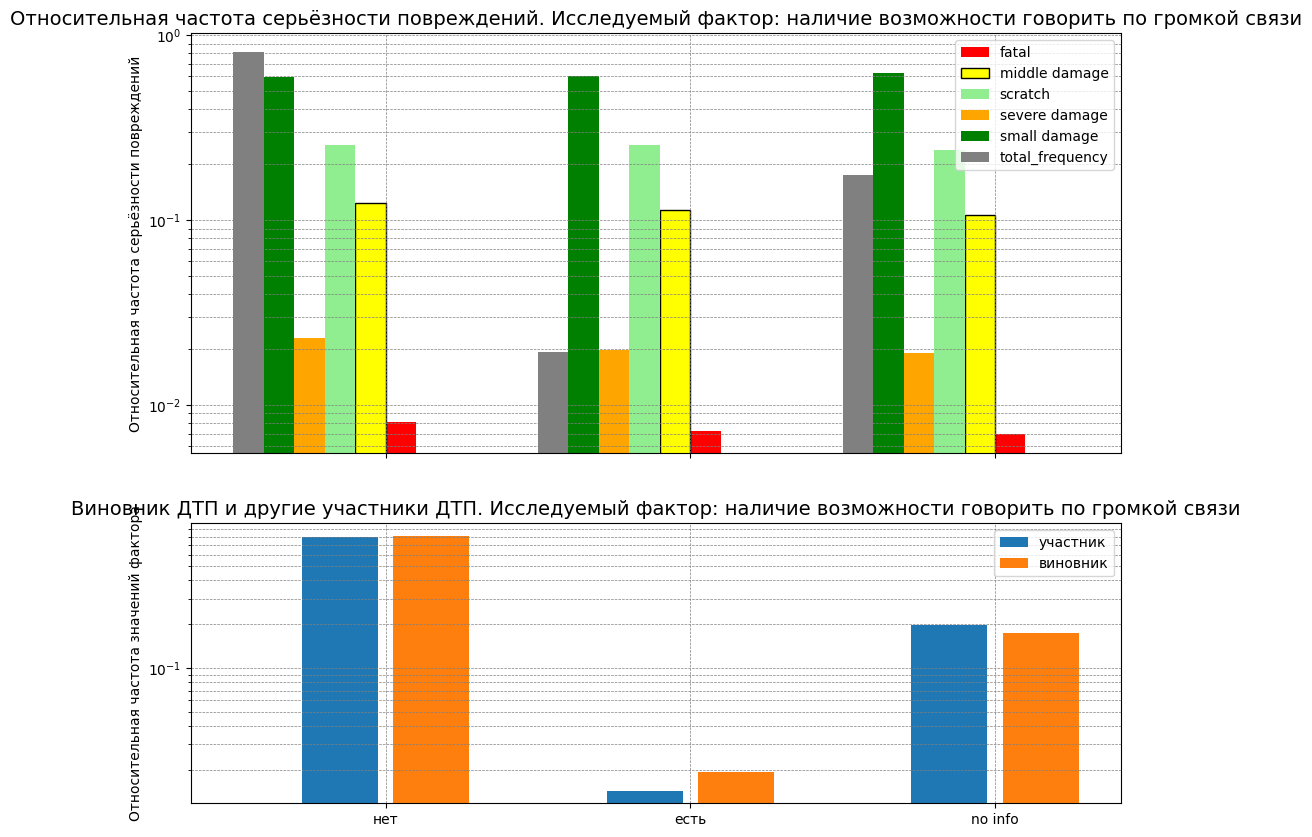

In [50]:
# Построим графики
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(12, 10),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.6, .4)})

# Тяжесть в зависимости от типа транспортного средства виновника
data = cellphone_data_f
factor = 'наличие возможности говорить по громкой связи'
rotation = 0
vert = True
factors_of_damage_show(data, factor, ax[0], rotation, vert)
# Посмотрим, какие типы транспортных средств чаще у виновников и у других участников ДТП
data = cellphone_data
fault_and_others_show(data, factor, ax[1], rotation, vert)
plt.show()

Выводы:
- ДТП чаще фиксировались, если возможности говорить по громкой связи не было,
- частота самых тяжёлых ДТП была в случае, когда в автомобиле виновника не было возможности говрить по громкой связи,
- среди автомобилей виновников ДТП доля тех, в которых отсутствовала возможность говориить по громкой связи, выше.

###  Повреждения и время дня, погода, освещение

Выясним, как связаны между собой погода, освещение и время дня в момент ДТП и серьёзность повреждений.

In [51]:
# Выберем требуемые данные для оценки влияния погоды
query = '''
SELECT weather,
       damage,
       count/SUM(count) OVER(PARTITION BY weather) AS relative_frequency,
       count/SUM(count) OVER() AS total_frequency
FROM   (SELECT weather_1 AS weather,
               collision_damage AS damage,
               COUNT(*) AS count
        FROM collisions
        GROUP BY weather_1, collision_damage
        ORDER BY weather_1, collision_damage) AS dmg_cnt
'''
weather_data = pd.read_sql_query(query, con=engine)
weather_data

weather         damage  relative_frequency  total_frequency
0     clear          fatal            0.007804         0.006249
1     clear  middle damage            0.122219         0.097866
2     clear        scratch            0.248233         0.198772
3     clear  severe damage            0.022635         0.018125
4     clear   small damage            0.599109         0.479736
5    cloudy          fatal            0.007536         0.001093
6    cloudy  middle damage            0.109225         0.015840
7    cloudy        scratch            0.242900         0.035226
8    cloudy  severe damage            0.019450         0.002821
9    cloudy   small damage            0.620889         0.090042
10      fog          fatal            0.018356         0.000081
11      fog  middle damage            0.116147         0.000511
12      fog        scratch            0.198018         0.000871
13      fog  severe damage            0.033788         0.000149
14      fog   small damage            0.633691         0.002786
15    other          fatal            0.011873         0.000013
16    other  middle damage            0.075198         0.000081
17    other        scratch            0.153034         0.000166
18    other  severe damage            0.025726         0.000028
19    other   small damage            0.734169         0.000795
20  raining          fatal            0.005658         0.000234
21  raining  middle damage            0.095350         0.003949
22  raining        scratch            0.254485         0.010539
23  raining  severe damage            0.016714         0.000692
24  raining   small damage            0.627794         0.025998
25  snowing          fatal            0.003890         0.000007
26  snowing  middle damage            0.088292         0.000162
27  snowing        scratch            0.167639         0.000308
28  snowing  severe damage            0.020226         0.000037
29  snowing   small damage            0.719953         0.001322
30     wind          fatal            0.009009         0.000003
31     wind  middle damage            0.105856         0.000034
32     wind        scratch            0.240991         0.000076
33     wind  severe damage            0.033784         0.000011
34     wind   small damage            0.610360         0.000194
35     None          fatal            0.005648         0.000029
36     None  middle damage            0.105111         0.000545
37     None        scratch            0.243284         0.001261
38     None  severe damage            0.019286         0.000100
39     None   small damage            0.626670         0.003249

In [52]:
# Заполним пропуски заглушкой
weather_data['weather'] = weather_data['weather'].fillna('other')
# Агрегируем данные в сводную таблицу
weather_data_g = weather_data.pivot_table(values=['relative_frequency'], index=['weather'],
                                            columns=['damage'], aggfunc='first')
weather_data_g.columns = weather_data_g.columns.droplevel()
weather_data = weather_data_g.merge(weather_data.pivot_table(values=['total_frequency'],
                                    index=['weather'],aggfunc='sum'),
                                    left_index=True, right_index=True)
weather_data = weather_data.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                        ascending=False)
weather_data

fatal  middle damage   scratch  severe damage  small damage  \
weather                                                                   
fog      0.018356       0.116147  0.198018       0.033788      0.633691   
other    0.011873       0.075198  0.153034       0.025726      0.734169   
wind     0.009009       0.105856  0.240991       0.033784      0.610360   
clear    0.007804       0.122219  0.248233       0.022635      0.599109   
cloudy   0.007536       0.109225  0.242900       0.019450      0.620889   
raining  0.005658       0.095350  0.254485       0.016714      0.627794   
snowing  0.003890       0.088292  0.167639       0.020226      0.719953   

         total_frequency  
weather                   
fog             0.004397  
other           0.006268  
wind            0.000317  
clear           0.800749  
cloudy          0.145021  
raining         0.041411  
snowing         0.001836

In [53]:
# Выберем требуемые данные для оценки влияния освещённости
query = '''
SELECT lighting,
       damage,
       count/SUM(count) OVER(PARTITION BY lighting) AS relative_frequency,
       count/SUM(count) OVER() AS total_frequency
FROM   (SELECT lighting,
               collision_damage AS damage,
               COUNT(*)
        FROM collisions
        GROUP BY lighting, collision_damage
        ORDER BY lighting, collision_damage) AS dmg_cnt
'''
lighting_data = pd.read_sql_query(query, con=engine)
lighting_data

lighting         damage  \
0                dark with no street lights          fatal   
1                dark with no street lights  middle damage   
2                dark with no street lights        scratch   
3                dark with no street lights  severe damage   
4                dark with no street lights   small damage   
5                   dark with street lights          fatal   
6                   dark with street lights  middle damage   
7                   dark with street lights        scratch   
8                   dark with street lights  severe damage   
9                   dark with street lights   small damage   
10  dark with street lights not functioning          fatal   
11  dark with street lights not functioning  middle damage   
12  dark with street lights not functioning        scratch   
13  dark with street lights not functioning  severe damage   
14  dark with street lights not functioning   small damage   
15                                 daylight          fatal   
16                                 daylight  middle damage   
17                                 daylight        scratch   
18                                 daylight  severe damage   
19                                 daylight   small damage   
20                             dusk or dawn          fatal   
21                             dusk or dawn  middle damage   
22                             dusk or dawn        scratch   
23                             dusk or dawn  severe damage   
24                             dusk or dawn   small damage   
25                                     None          fatal   
26                                     None  middle damage   
27                                     None        scratch   
28                                     None  severe damage   
29                                     None   small damage   

    relative_frequency  total_frequency  
0             0.022963         0.001741  
1             0.133390         0.010116  
2             0.163634         0.012409  
3             0.039795         0.003018  
4             0.640219         0.048551  
5             0.010244         0.002136  
6             0.116497         0.024289  
7             0.218814         0.045621  
8             0.027038         0.005637  
9             0.627407         0.130809  
10            0.021423         0.000064  
11            0.124256         0.000373  
12            0.201857         0.000606  
13            0.034992         0.000105  
14            0.617472         0.001853  
15            0.005042         0.003392  
16            0.118170         0.079507  
17            0.266101         0.179039  
18            0.018195         0.012242  
19            0.592492         0.398641  
20            0.010064         0.000339  
21            0.121041         0.004081  
22            0.243713         0.008216  
23            0.025445         0.000858  
24            0.599737         0.020219  
25            0.005935         0.000036  
26            0.101478         0.000623  
27            0.216339         0.001328  
28            0.016641         0.000102  
29            0.659607         0.004049

In [54]:
# Изменим наименования категорий
map = {'dark with no street lights':'темно, не освещено',
       'dark with street lights':'темно, освещено',
       'dark with street lights not functioning':'темно, не работает освещение',
       'daylight':'светло',
       'dusk or dawn':'сумерки/рассвет'
}
lighting_data['lighting'] = lighting_data['lighting'].replace(map)
lighting_data['lighting'].value_counts(dropna=False)

lighting
темно, не освещено              5
темно, освещено                 5
темно, не работает освещение    5
светло                          5
сумерки/рассвет                 5
None                            5
Name: count, dtype: int64

In [55]:
# Заполним пропуски заглушкой
lighting_data['lighting'] = lighting_data['lighting'].fillna('other')
# Агрегируем данные в сводную таблицу
lighting_data_g = lighting_data.pivot_table(values=['relative_frequency'], index=['lighting'],
                                            columns=['damage'], aggfunc='first')
lighting_data_g.columns = lighting_data_g.columns.droplevel()
lighting_data = lighting_data_g.merge(lighting_data.pivot_table(values=['total_frequency'],
                                      index=['lighting'],aggfunc='sum'),
                                      left_index=True, right_index=True)
lighting_data = lighting_data.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                          ascending=False)
lighting_data

fatal  middle damage   scratch  \
lighting                                                          
темно, не освещено            0.022963       0.133390  0.163634   
темно, не работает освещение  0.021423       0.124256  0.201857   
темно, освещено               0.010244       0.116497  0.218814   
сумерки/рассвет               0.010064       0.121041  0.243713   
other                         0.005935       0.101478  0.216339   
светло                        0.005042       0.118170  0.266101   

                              severe damage  small damage  total_frequency  
lighting                                                                    
темно, не освещено                 0.039795      0.640219         0.075836  
темно, не работает освещение       0.034992      0.617472         0.003001  
темно, освещено                    0.027038      0.627407         0.208491  
сумерки/рассвет                    0.025445      0.599737         0.033714  
other                              0.016641      0.659607         0.006138  
светло                             0.018195      0.592492         0.672821

In [56]:
# Выберем требуемые данные для оценки влияния времени суток
query = '''
SELECT hour,
       damage,
       count/SUM(count) OVER(PARTITION BY hour) AS relative_frequency,
       count/SUM(count) OVER() AS total_frequency
FROM   (SELECT EXTRACT(hour FROM collision_time) AS hour,
               collision_damage AS damage,
               COUNT(*)
        FROM collisions
        GROUP BY hour, collision_damage
        ORDER BY hour, collision_damage) AS dmg_cnt
'''
time_data = pd.read_sql_query(query, con=engine)
time_data

hour         damage  relative_frequency  total_frequency
0     0.0          fatal            0.016378         0.000309
1     0.0  middle damage            0.136886         0.002585
2     0.0        scratch            0.151600         0.002863
3     0.0  severe damage            0.036198         0.000684
4     0.0   small damage            0.658938         0.012444
..    ...            ...                 ...              ...
120   NaN          fatal            0.014381         0.000126
121   NaN  middle damage            0.021287         0.000187
122   NaN        scratch            0.026893         0.000236
123   NaN  severe damage            0.006825         0.000060
124   NaN   small damage            0.930614         0.008181

[125 rows x 4 columns]

In [57]:
# Заполним пропуски заглушкой
time_data['hour'] = time_data['hour'].fillna('no info')
time_data.loc[time_data['hour']!='no info', 'hour'] = time_data.loc[time_data['hour']!='no info', 'hour'].astype('int')
# Агрегируем данные в сводную таблицу
time_data_g = time_data.pivot_table(values=['relative_frequency'], index=['hour'],
                                          columns=['damage'], aggfunc='first')
time_data_g.columns = time_data_g.columns.droplevel()
time_data = time_data_g.merge(time_data.pivot_table(values=['total_frequency'],
                              index=['hour'],aggfunc='sum'),
                              left_index=True, right_index=True)
time_data

fatal  middle damage   scratch  severe damage  small damage  \
hour                                                                      
0        0.016378       0.136886  0.151600       0.036198      0.658938   
1        0.017662       0.144038  0.134343       0.038405      0.665552   
2        0.017955       0.145625  0.124340       0.039027      0.673053   
3        0.018907       0.143866  0.127295       0.035260      0.674671   
4        0.017044       0.133792  0.142838       0.034677      0.671649   
5        0.018471       0.118600  0.196593       0.030504      0.635832   
6        0.011317       0.116572  0.227930       0.023255      0.620927   
7        0.004709       0.109717  0.266439       0.016635      0.602500   
8        0.004275       0.097983  0.264534       0.012891      0.620318   
9        0.005076       0.107923  0.262856       0.015806      0.608339   
10       0.005239       0.116894  0.262971       0.017093      0.597804   
11       0.005826       0.119097  0.268413       0.018508      0.588157   
12       0.004695       0.117641  0.269877       0.018000      0.589787   
13       0.004814       0.119453  0.269709       0.018243      0.587781   
14       0.005070       0.121047  0.269453       0.017534      0.586895   
15       0.004553       0.121059  0.270162       0.017484      0.586742   
16       0.004689       0.118518  0.270846       0.019159      0.586788   
17       0.006029       0.114968  0.279671       0.020422      0.578910   
18       0.007145       0.120595  0.270961       0.022919      0.578380   
19       0.010192       0.124466  0.257587       0.028401      0.579354   
20       0.012274       0.129405  0.240398       0.031742      0.586182   
21       0.012274       0.126142  0.223092       0.030216      0.608276   
22       0.011430       0.122490  0.205945       0.032734      0.627401   
23       0.014071       0.131678  0.169867       0.033396      0.650988   
no info  0.014381       0.021287  0.026893       0.006825      0.930614   

         total_frequency  
hour                      
0               0.018884  
1               0.019008  
2               0.020169  
3               0.013147  
4               0.010896  
5               0.014424  
6               0.024111  
7               0.050969  
8               0.053471  
9               0.042074  
10              0.042541  
11              0.048550  
12              0.056904  
13              0.058457  
14              0.065789  
15              0.075619  
16              0.071134  
17              0.078661  
18              0.063578  
19              0.043661  
20              0.035150  
21              0.032764  
22              0.027996  
23              0.023249  
no info         0.008791

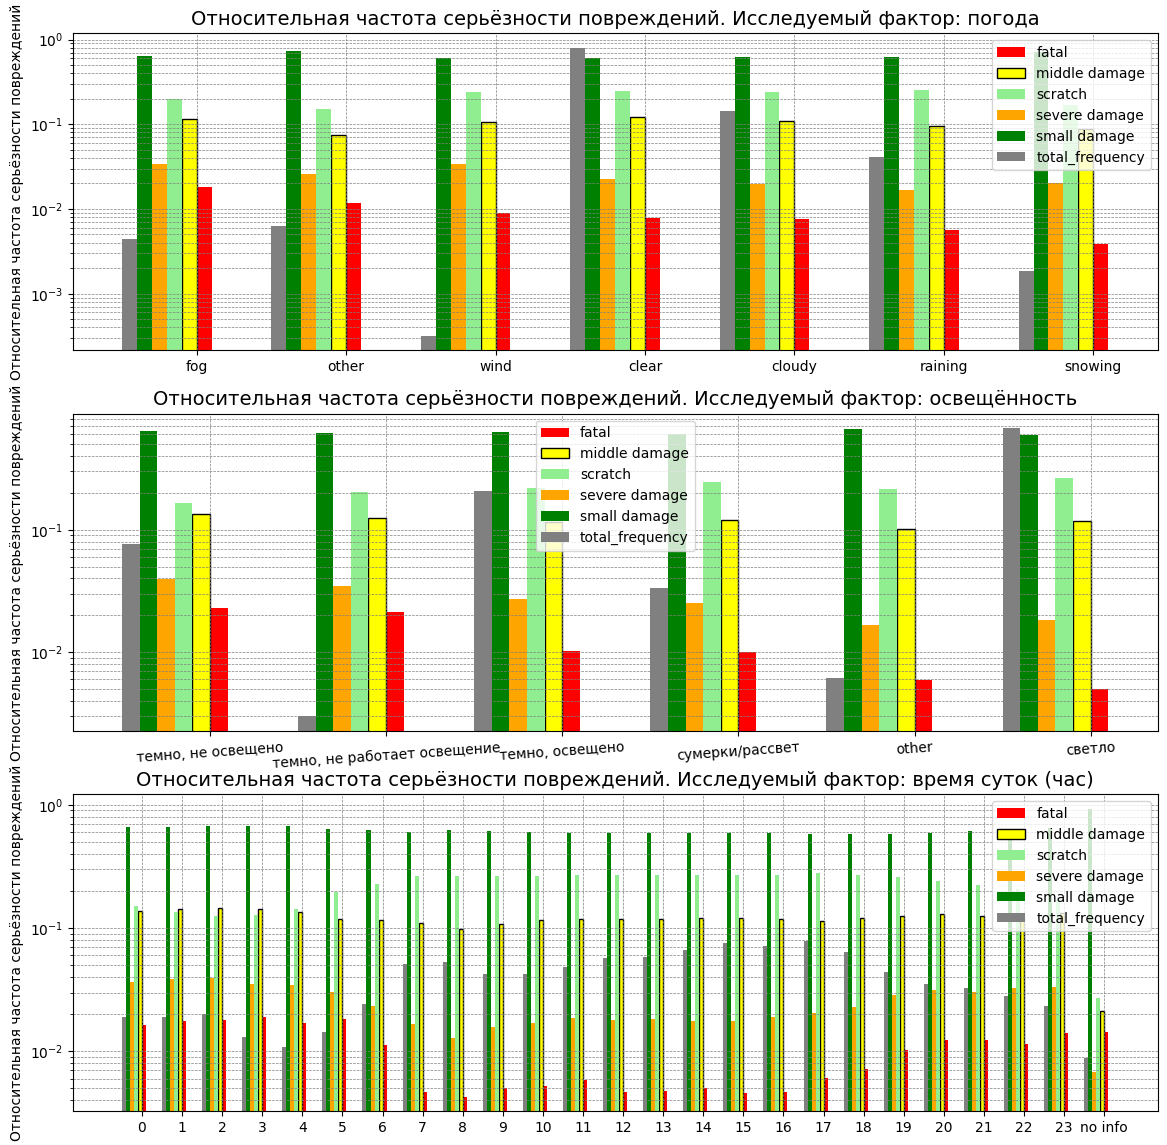

In [58]:
# Посмотрим, как связана тяжесть повреждений и рассматриваемые факторы
fig, ax = plt.subplots(ncols=1, nrows=3,
                       figsize=(14, 14),
                       sharex=False,
                       gridspec_kw={'height_ratios': (.33, .33, .33)})

rotation = 0
# В зависимости от погоды
data = weather_data
factor = 'погода'
vert = True
factors_of_damage_show(data, factor, ax[0], rotation, vert)
# В зависимости от времени суток
data = time_data
factor = 'время суток (час)'
factors_of_damage_show(data, factor, ax[2], rotation, vert)
# В зависимости от освещённости
rotation = 4
data = lighting_data
factor = 'освещённость'
factors_of_damage_show(data, factor, ax[1], rotation, vert)

plt.show()

Выводы.
Наибольшая частота ДТП с самыми тяжёлыми последствиями (fatal, не подлежит восстановлению) наблюдается в случаях:
- туман, отсутствует или не работает освещение, 
- с 0 до 5 часов.

Наибольшая частота ДТП с тяжёлыми последствиями (severe, серьёзный ремонт, большая часть под замену/серьёзное повреждение капитального строения) наблюдается в случаях:
- туман, ветер, отсутствует или не работает освещение,
- с 0 до 5 часов.

Средние (middle, средний ремонт, машина в целом на ходу/Строение в целом устояло) и незначительные повреждения встречаются приблизительно с одинаковой частотой при различной погоде, освещённости и времени суток.

Царапины чаще наблюдаются с 7 до 20 часов, при различной погоде и освещённости царапины встречаются с приблизительно одинаковой частотой.

Чаще всего ДТП происходили в ясную или облачную погоду, в светлое время суток или на освещённой дороге, с 7 до 20 часов.

###  ДТП и географические данные

Выясним, как связаны между собой частота аварий и следующие факторы:
- географический район, где произошло ДТП,
- направление движения,
- расстояние от главной дороги,
- тип дороги,
- перекрёсток был или нет.

####  Частота ДТП и географический район

In [59]:
# Выберем требуемые данные по географическому району
query = '''
SELECT loc_name,
       loc_number,       
       col_cnt/SUM(col_cnt) OVER() AS relative_frequency
FROM   (SELECT county_city_location AS loc_number,
               county_location AS loc_name,
               COUNT(*) AS col_cnt
        FROM collisions
        GROUP BY loc_number, loc_name
        ORDER BY loc_number, loc_name) AS location_cnt
'''
location_data = pd.read_sql_query(query, con=engine)
location_data

loc_name loc_number  relative_frequency
0    alameda       0100            0.005656
1    alameda       0101            0.001876
2    alameda       0102            0.000559
3    alameda       0103            0.003611
4    alameda       0104            0.000930
..       ...        ...                 ...
533     yolo       5703            0.001207
534     yolo       5704            0.001489
535     yuba       5800            0.001404
536     yuba       5801            0.000204
537     yuba       5802            0.000054

[538 rows x 3 columns]

In [60]:
# Посмотрим, как связаны наименования региона и код региона
# Определим количество уникальных наименований и количество уникальных кодов (первые две цифры)
location_data['loc_code'] = location_data['loc_number'].str[:2]
print(f'Уникальных наименований регионов {location_data["loc_name"].nunique()}')
print(f'Уникальных кодов региона (первые две цифры) {location_data["loc_code"].nunique()}')
loc_unique = location_data.groupby(by= ['loc_name', 'loc_code'])['relative_frequency'].agg('first').count()
print(f'Уникальных сочетаний наименований регионов и кода региона {loc_unique}')

Уникальных наименований регионов 58
Уникальных кодов региона (первые две цифры) 58
Уникальных сочетаний наименований регионов и кода региона 58


Рассмотрим частоту ДТП по регионам. Далее выборочно посмотрим частоту аварий по локациям внутри регионов, в которых аварии случаются чаще, чем в других регионах.

In [61]:
location_data = location_data.drop(['loc_code'], axis=1)
# Агрегируем данные в сводную таблицу
region_data = location_data.pivot_table(values=['relative_frequency'], index=['loc_name'], aggfunc='sum')
region_data = pd.Series(region_data.values.flatten(), index = region_data.index)
region_data = region_data.sort_values(ascending=True)

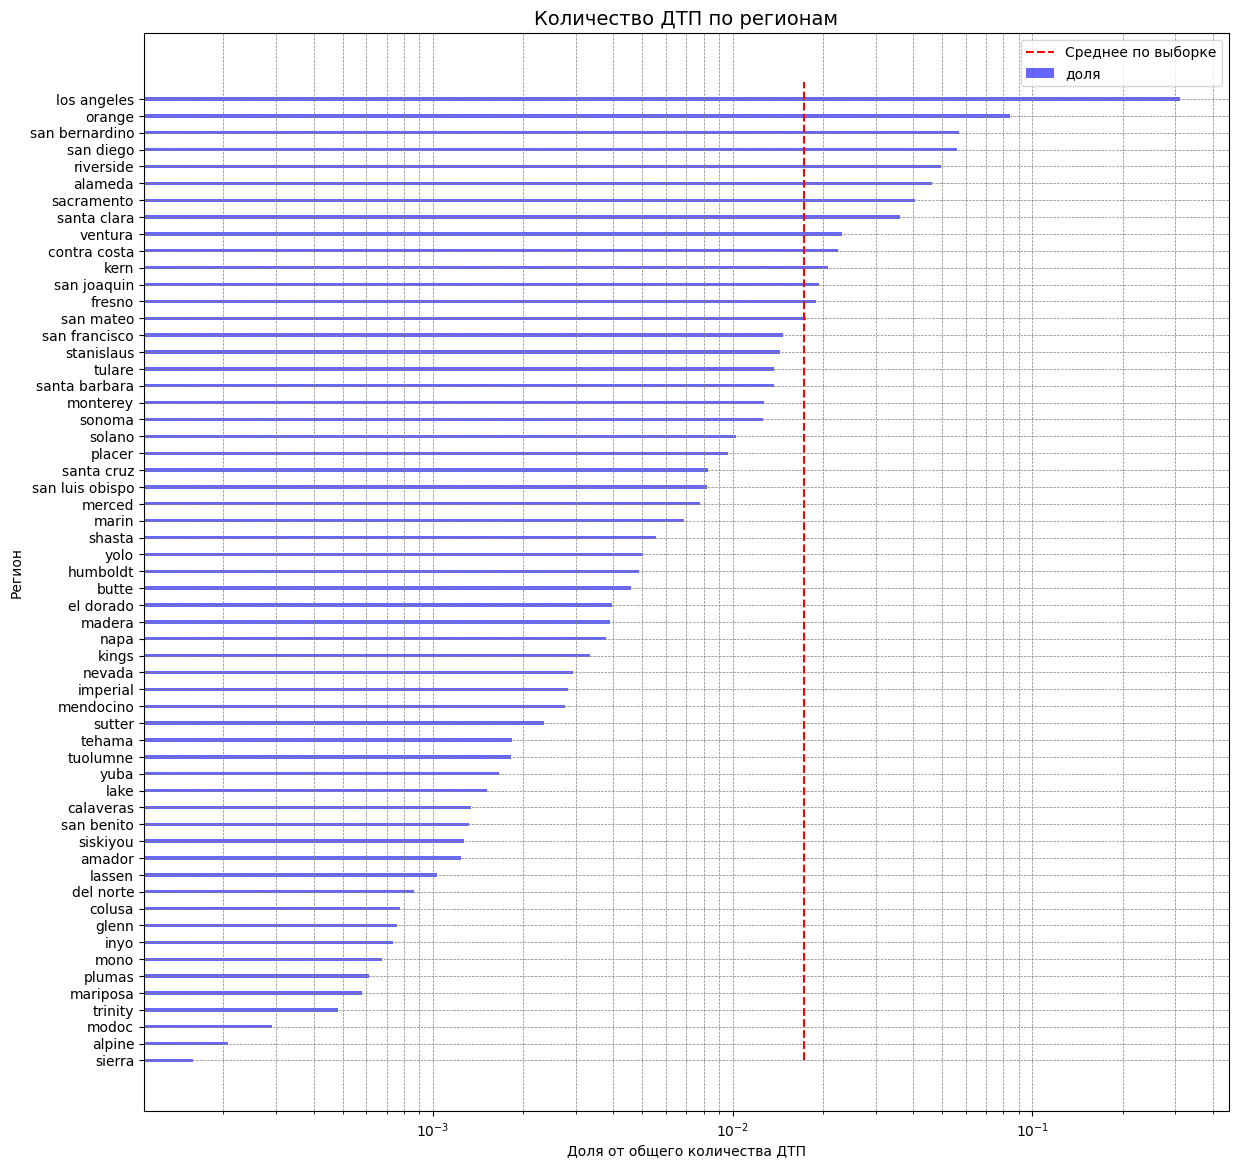

In [62]:
# Построим график для визуализации данных
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(14, 14))
ax.set_title('Количество ДТП по регионам', fontsize=14)
ax.grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')
ax.set_ylabel('Регион')
ax.set_xlabel('Доля от общего количества ДТП')
ax.set_xscale('log')
y_axe = np.arange(region_data.shape[0])
ax.set_yticks(y_axe)
ax.set_yticklabels(region_data.index)
ax.barh(y=y_axe, width=region_data, height=0.2,
         align='center', label='доля', color='blue', alpha=0.6)
ax.plot([region_data.mean(), region_data.mean()],
         [0, region_data.shape[0]], linestyle='--', color='red', label='Среднее по выборке')
ax.legend()
plt.show()

По диаграммам можем заключить, что наибольшая частота всех ДТП наблюдается в крупных городах. Посмотрим, как распределено количество ДТП внутри региона с максимальным количеством ДТП.

In [63]:
# Агрегируем данные в сводную таблицу
max_region_data = location_data.loc[location_data['loc_name']=='los angeles',
                                    ['loc_number', 'relative_frequency']].copy()
max_region_data['relative_frequency'] = max_region_data['relative_frequency']/ \
                                        max_region_data['relative_frequency'].sum()
max_region_data = max_region_data.sort_values(by='relative_frequency', ascending=True)
max_region_data

loc_number  relative_frequency
126       1911            0.000002
172       1957            0.000030
145       1930            0.000035
181       1966            0.000106
203       1999            0.000288
..         ...                 ...
168       1953            0.020041
140       1925            0.023001
156       1941            0.048745
116       1900            0.114308
157       1942            0.392650

[88 rows x 2 columns]

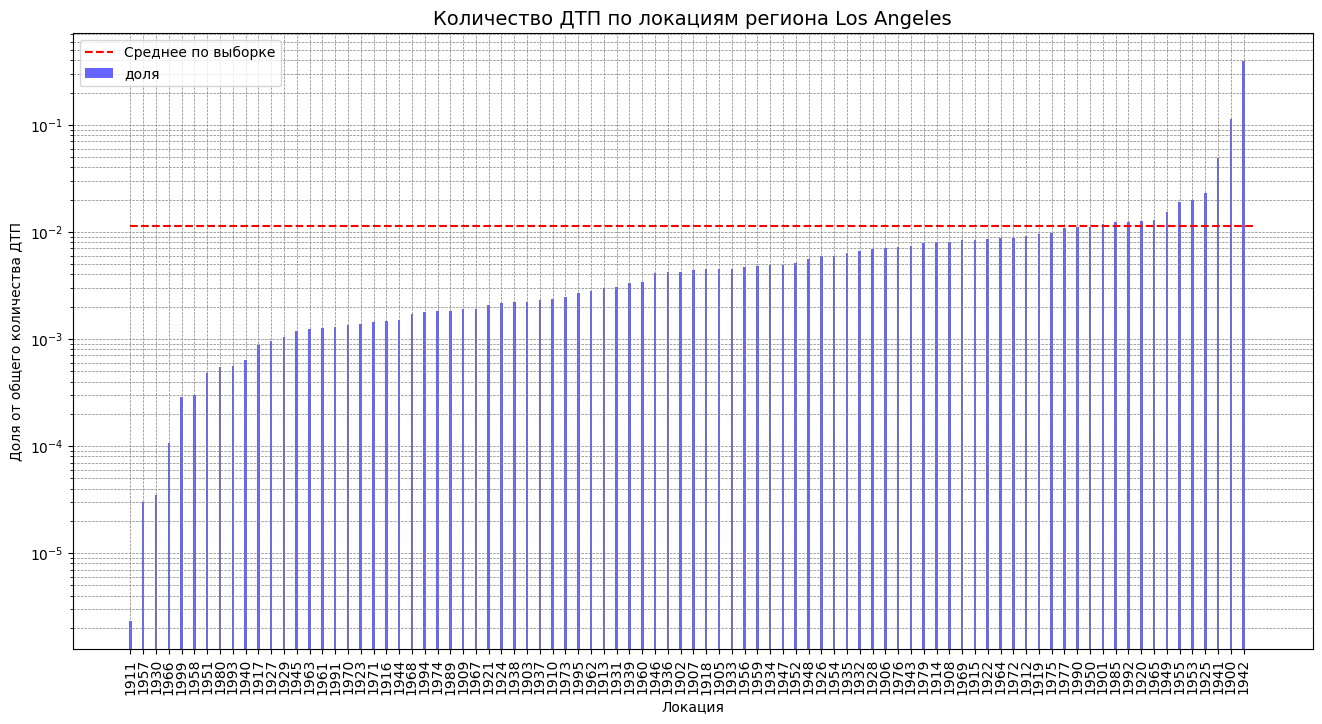

In [64]:
# Построим график для визуализации данных
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(16, 8))
ax.set_title('Количество ДТП по локациям региона Los Angeles', fontsize=14)
ax.grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')
ax.set_xlabel('Локация')
ax.set_ylabel('Доля от общего количества ДТП')
ax.set_yscale('log')
x_axe = np.arange(max_region_data.shape[0])
ax.set_xticks(x_axe)
ax.set_xticklabels(max_region_data['loc_number'], rotation=90)
ax.bar(x=x_axe, height=max_region_data['relative_frequency'], width=0.2,
         align='center', label='доля', color='blue', alpha=0.6)
ax.plot([0, max_region_data.shape[0]],
        [max_region_data['relative_frequency'].mean(), max_region_data['relative_frequency'].mean()],
        linestyle='--', color='red', label='Среднее по выборке')
ax.legend()
plt.show()

Вывод:  
внутри региона частота ДТП может отличаться от локации к локации очень существенно.

####  Повреждения и направление движения

In [65]:
# Выберем требуемые данные по направлению движения
query = '''
SELECT direction,
       damage,
       count/SUM(count) OVER(PARTITION BY direction) AS relative_frequency,
       count/SUM(count) OVER() AS total_frequency
FROM   (SELECT direction,
               collision_damage AS damage,
               COUNT(*)
        FROM collisions
        GROUP BY direction, collision_damage
        ORDER BY direction, collision_damage) AS dmg_cnt
'''
direction_data = pd.read_sql_query(query, con=engine)
direction_data

direction         damage  relative_frequency  total_frequency
0       east          fatal            0.008629         0.001483
1       east  middle damage            0.112789         0.019381
2       east        scratch            0.225311         0.038717
3       east  severe damage            0.022467         0.003861
4       east   small damage            0.630804         0.108396
5      north          fatal            0.007872         0.001623
6      north  middle damage            0.107230         0.022106
7      north        scratch            0.220384         0.045433
8      north  severe damage            0.021506         0.004434
9      north   small damage            0.643008         0.132558
10     south          fatal            0.008137         0.001689
11     south  middle damage            0.107868         0.022384
12     south        scratch            0.220083         0.045669
13     south  severe damage            0.020767         0.004309
14     south   small damage            0.643145         0.133459
15      west          fatal            0.008132         0.001392
16      west  middle damage            0.111697         0.019121
17      west        scratch            0.224976         0.038512
18      west  severe damage            0.022290         0.003816
19      west   small damage            0.632905         0.108343
20      None          fatal            0.006259         0.001523
21      None  middle damage            0.147941         0.035996
22      None        scratch            0.324217         0.078887
23      None  severe damage            0.022781         0.005543
24      None   small damage            0.498802         0.121366

In [66]:
# Заполним пропуски заглушкой
direction_data['direction'] = direction_data['direction'].fillna('no info')
# Агрегируем данные в сводную таблицу
direction_data_g = direction_data.pivot_table(values=['relative_frequency'], index=['direction'],
                                              columns=['damage'], aggfunc='first')
direction_data_g.columns = direction_data_g.columns.droplevel()
direction_data = direction_data_g.merge(direction_data.pivot_table(values=['total_frequency'],
                                        index=['direction'],aggfunc='sum'),
                                        left_index=True, right_index=True)
direction_data = direction_data.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                            ascending=False)
direction_data

fatal  middle damage   scratch  severe damage  small damage  \
direction                                                                   
east       0.008629       0.112789  0.225311       0.022467      0.630804   
south      0.008137       0.107868  0.220083       0.020767      0.643145   
west       0.008132       0.111697  0.224976       0.022290      0.632905   
north      0.007872       0.107230  0.220384       0.021506      0.643008   
no info    0.006259       0.147941  0.324217       0.022781      0.498802   

           total_frequency  
direction                   
east              0.171839  
south             0.207509  
west              0.171184  
north             0.206153  
no info           0.243316

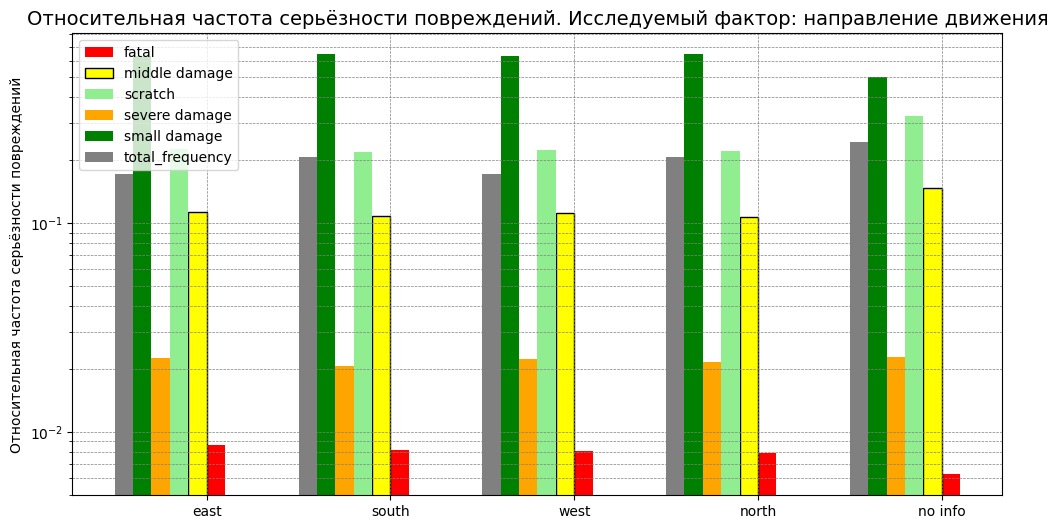

In [67]:
# Построим графики
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(12, 6),
                       sharex=True)
data = direction_data
factor = 'направление движения'
rotation = 0
vert = True
factors_of_damage_show(data, factor, ax, rotation, vert)
plt.show()

Вывод:  
тяжесть повреждений и частота ДТП практически не зависит от направления движения.

####  Частота ДТП и расстояние от главной дороги

In [68]:
# Выберем требуемые данные по расстоянию до главной дороги
query = '''
SELECT distance
FROM collisions
ORDER BY distance ASC
'''
distance_data = pd.read_sql_query(query, con=engine)
distance_data

distance
0              0.0
1              0.0
2              0.0
3              0.0
4              0.0
...            ...
1399995  2735040.0
1399996  2851200.0
1399997  3263040.0
1399998  5607360.0
1399999  8363520.0

[1400000 rows x 1 columns]

In [69]:
# Изучим данные подробнее
distance_data.describe()

distance
count  1.400000e+06
mean   6.607115e+02
std    1.178579e+04
min    0.000000e+00
25%    2.000000e+00
50%    1.000000e+02
75%    4.300000e+02
max    8.363520e+06

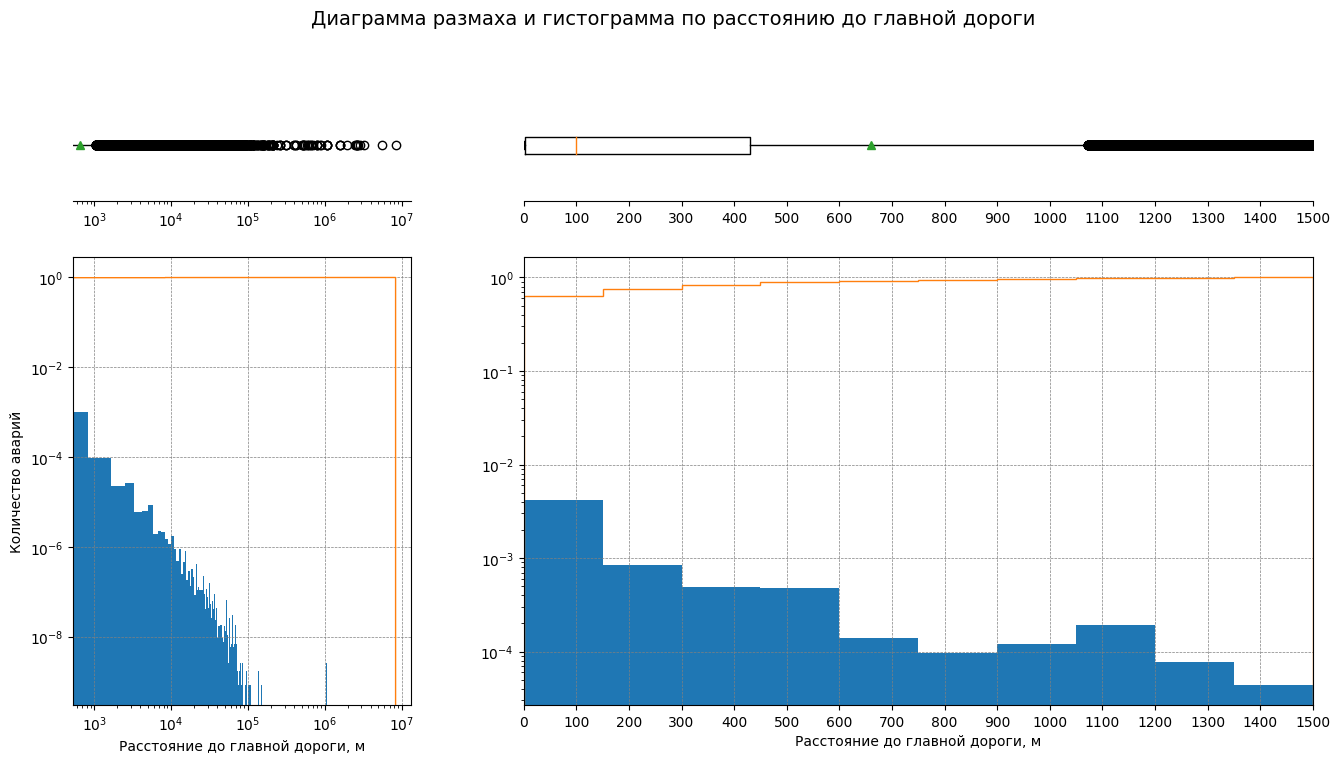

In [70]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку расстояние в большинстве случаев не превышает 1500 м, а максимальное значение ~8363 км,
# то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон, а справа - с ограничением максимального расстояния до 1500 м.
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=2, nrows=2,
                       figsize=(16, 8),
                       sharex=False,
                       gridspec_kw={'height_ratios': (.2, .8), 'width_ratios': (.3, .7)})
fig.suptitle('Диаграмма размаха и гистограмма по расстоянию до главной дороги', fontsize=14)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].tick_params(axis='y', left=False, labelleft=False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].tick_params(axis='y', left=False, labelleft=False)
ax[1,0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1,1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[0,0].sharex(ax[1, 0])
ax[0,1].sharex(ax[1, 1])
ax[1,1].set_xticks(range(0, 1501, 100))
ax[1,1].set_xlim(0,1500)
ax[1,0].set_xlabel('Расстояние до главной дороги, м')
ax[1,0].set_ylabel('Количество аварий')
ax[1,1].set_xlabel('Расстояние до главной дороги, м')
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
# Построим сами диаграммы
ax[0,0].boxplot(distance_data, vert=False, showmeans=True)
ax[0,1].boxplot(distance_data, vert=False, showmeans=True)
ax[1,0].hist(distance_data, density=True, bins=10000)
ax[1,0].hist(distance_data, density=True, histtype='step', cumulative=True, bins=1000)
ax[1,1].hist(distance_data, range=(0, 1500), density=True, bins=10)
ax[1,1].hist(distance_data, range=(0, 1500), density=True, histtype='step', cumulative=True, bins=10)
plt.show()

Вывод:  
большинство ДТП произошло на расстоянии до 1,5 км от главной дороги.

####  Повреждения и тип дороги

In [71]:
# Выберем требуемые данные по направлению движения
query = '''
SELECT road_type,
       damage,
       count/SUM(count) OVER(PARTITION BY road_type) AS relative_frequency,
       count/SUM(count) OVER() AS total_frequency
FROM   (SELECT location_type AS road_type,
               collision_damage AS damage,
               COUNT(*)
        FROM collisions
        GROUP BY road_type, damage
        ORDER BY road_type, damage) AS dmg_cnt
'''
road_type_data = pd.read_sql_query(query, con=engine)
road_type_data

road_type         damage  relative_frequency  total_frequency
0        highway          fatal            0.009068         0.002698
1        highway  middle damage            0.096679         0.028764
2        highway        scratch            0.214719         0.063884
3        highway  severe damage            0.020191         0.006007
4        highway   small damage            0.659343         0.196169
5   intersection          fatal            0.011480         0.000219
6   intersection  middle damage            0.133891         0.002549
7   intersection        scratch            0.276823         0.005271
8   intersection  severe damage            0.027649         0.000526
9   intersection   small damage            0.550158         0.010475
10          ramp          fatal            0.005173         0.000279
11          ramp  middle damage            0.093264         0.005036
12          ramp        scratch            0.221386         0.011954
13          ramp  severe damage            0.015240         0.000823
14          ramp   small damage            0.664938         0.035903
15          None          fatal            0.007171         0.004514
16          None  middle damage            0.131288         0.082639
17          None        scratch            0.263901         0.166111
18          None  severe damage            0.023204         0.014606
19          None   small damage            0.574436         0.361575

In [72]:
# Заполним пропуски заглушкой
road_type_data['road_type'] = road_type_data['road_type'].fillna('no info')
# Агрегируем данные в сводную таблицу
road_type_data_g = road_type_data.pivot_table(values=['relative_frequency'], index=['road_type'],
                                            columns=['damage'], aggfunc='first')
road_type_data_g.columns = road_type_data_g.columns.droplevel()
road_type_data = road_type_data_g.merge(road_type_data.pivot_table(values=['total_frequency'],
                                        index=['road_type'],aggfunc='sum'),
                                        left_index=True, right_index=True)
road_type_data = road_type_data.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                            ascending=False)
road_type_data

fatal  middle damage   scratch  severe damage  small damage  \
road_type                                                                      
intersection  0.011480       0.133891  0.276823       0.027649      0.550158   
highway       0.009068       0.096679  0.214719       0.020191      0.659343   
no info       0.007171       0.131288  0.263901       0.023204      0.574436   
ramp          0.005173       0.093264  0.221386       0.015240      0.664938   

              total_frequency  
road_type                      
intersection         0.019040  
highway              0.297522  
no info              0.629444  
ramp                 0.053994

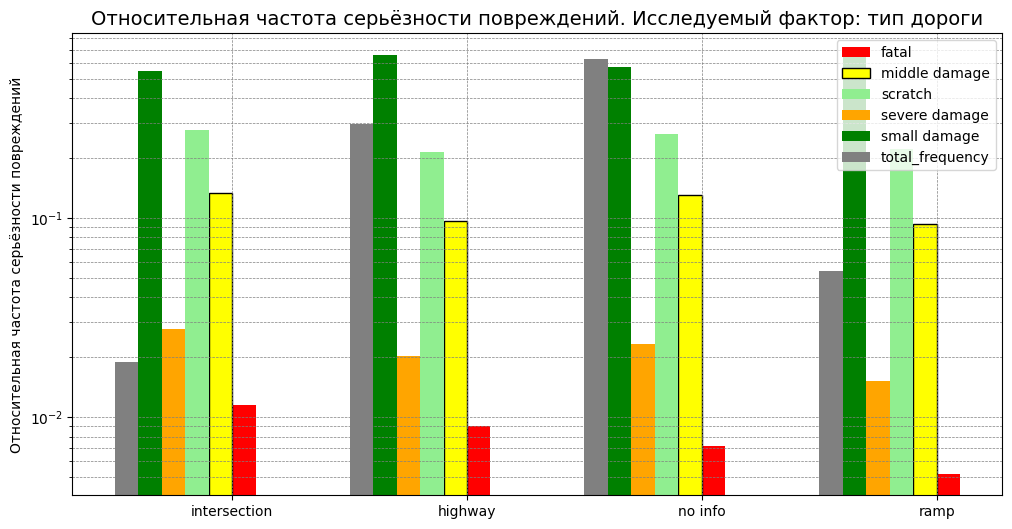

In [73]:
# Построим графики
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(12, 6),
                       sharex=True)
data = road_type_data
factor = 'тип дороги'
rotation = 0
vert = True
factors_of_damage_show(data, factor, ax, rotation, vert)
plt.show()

Вывод: самые тяжёлые ДТП (fatal и severe) чаще возникают на перекрёстках или шоссе highway, чаще всего ДТП происходят на шоссе highway.

####  Перекрёсток или нет

In [74]:
# Выберем требуемые данные по направлению движения
query = '''
SELECT intersection,
       damage,
       count/SUM(count) OVER(PARTITION BY intersection) AS relative_frequency,
       count/SUM(count) OVER() AS total_frequency
FROM   (SELECT intersection,
               collision_damage AS damage,
               COUNT(*)
        FROM collisions
        GROUP BY intersection, damage
        ORDER BY intersection, damage) AS dmg_cnt
'''
intersection_data = pd.read_sql_query(query, con=engine)
intersection_data

intersection         damage  relative_frequency  total_frequency
0            0.0          fatal            0.008141         0.006255
1            0.0  middle damage            0.109470         0.084109
2            0.0        scratch            0.222087         0.170635
3            0.0  severe damage            0.021634         0.016622
4            0.0   small damage            0.638668         0.490706
5            1.0          fatal            0.006488         0.001446
6            1.0  middle damage            0.152593         0.034020
7            1.0        scratch            0.335370         0.074769
8            1.0  severe damage            0.023295         0.005194
9            1.0   small damage            0.482254         0.107516
10           NaN          fatal            0.000900         0.000008
11           NaN  middle damage            0.098453         0.000859
12           NaN        scratch            0.207873         0.001814
13           NaN  severe damage            0.016777         0.000146
14           NaN   small damage            0.675996         0.005900

In [75]:
# Заполним пропуски заглушкой
intersection_data['intersection'] = intersection_data['intersection'].fillna('no info')
intersection_data['intersection'] = intersection_data['intersection'].replace({0:'не перекрёсток',
                                                                               1:'перекрёсток'})
# Агрегируем данные в сводную таблицу
intersection_data_g = intersection_data.pivot_table(values=['relative_frequency'], index=['intersection'],
                                                      columns=['damage'], aggfunc='first')
intersection_data_g.columns = intersection_data_g.columns.droplevel()
intersection_data = intersection_data_g.merge(intersection_data.pivot_table(values=['total_frequency'],
                                              index=['intersection'],aggfunc='sum'),
                                              left_index=True, right_index=True)
intersection_data = intersection_data.sort_values(by=['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch'],
                                            ascending=False)
intersection_data

fatal  middle damage   scratch  severe damage  \
intersection                                                       
не перекрёсток  0.008141       0.109470  0.222087       0.021634   
перекрёсток     0.006488       0.152593  0.335370       0.023295   
no info         0.000900       0.098453  0.207873       0.016777   

                small damage  total_frequency  
intersection                                   
не перекрёсток      0.638668         0.768326  
перекрёсток         0.482254         0.222946  
no info             0.675996         0.008728

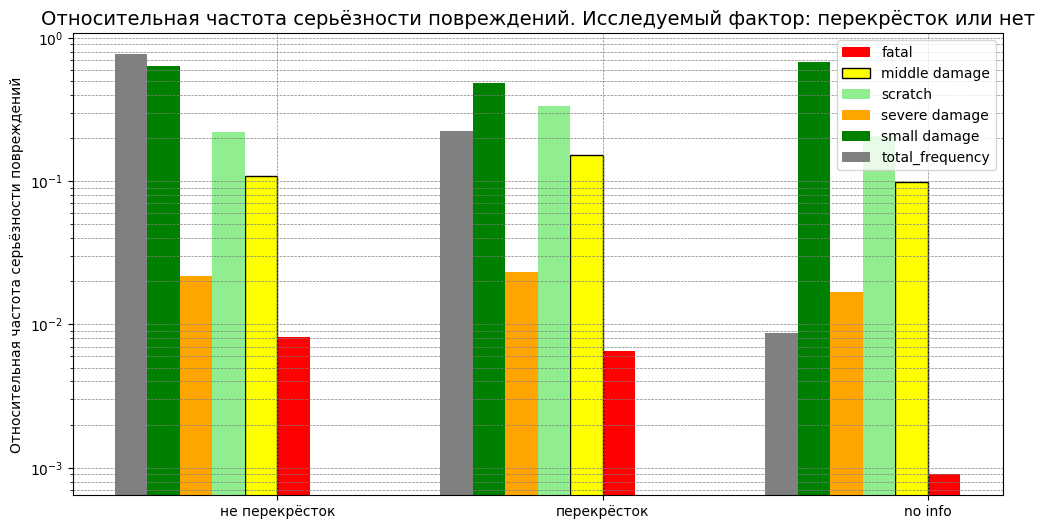

In [76]:
# Построим графики
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(12, 6),
                       sharex=True)
data = intersection_data
factor = 'перекрёсток или нет'
rotation = 0
vert = True
factors_of_damage_show(data, factor, ax, rotation, vert)
plt.show()

Вывод: тяжесть повреждений между перекрёстками и не перекрёстками распределена приблизительно одинаково, ДТП чаще встречаются не на перекрёстках.

###  Особенности ДТП

Выясним, как часто происходили ДТП в зависимости от факторов:
- количество участников ДТП,
- тип аварии,
- дополнительные участники ДТП,
- функционирует устройство управления или нет.

####  Количество участников ДТП

In [77]:
# Выберем требуемые данные по количеству участников
query = '''
SELECT party_count,       
       col_cnt/SUM(col_cnt) OVER() AS relative_frequency
FROM   (SELECT party_count,
               COUNT(*) AS col_cnt
        FROM collisions
        GROUP BY party_count
        ORDER BY party_count) AS party_cnt
'''
party_count_data = pd.read_sql_query(query, con=engine)
party_count_data

party_count  relative_frequency
0             1        1.962614e-01
1             2        6.766079e-01
2             3        1.002143e-01
3             4        2.099214e-02
4             5        4.440714e-03
5             6        1.032857e-03
6             7        2.757143e-04
7             8        1.000000e-04
8             9        3.357143e-05
9            10        2.142857e-05
10           11        5.000000e-06
11           12        5.000000e-06
12           13        5.000000e-06
13           14        1.428571e-06
14           15        1.428571e-06
15           20        7.142857e-07
16           21        7.142857e-07
17           27        7.142857e-07

Рассмотрим частоту ДТП при различном количестве участников ДТП.

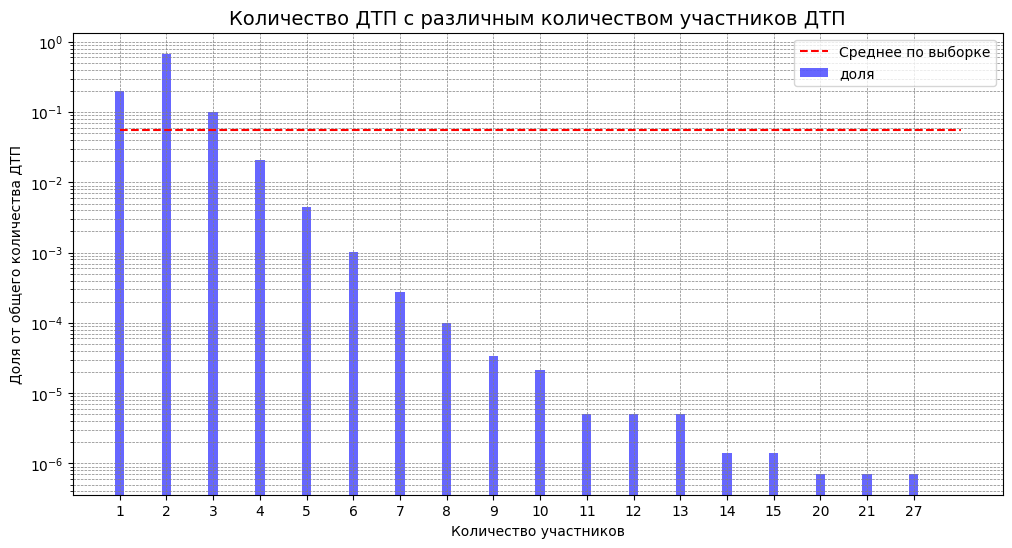

In [78]:
# Построим график для визуализации данных
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(12, 6))
ax.set_title('Количество ДТП с различным количеством участников ДТП', fontsize=14)
ax.grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')
ax.set_xlabel('Количество участников')
ax.set_ylabel('Доля от общего количества ДТП')
ax.set_yscale('log')
x_axe = np.arange(party_count_data.shape[0])
ax.set_xticks(x_axe)
ax.set_xticklabels(party_count_data['party_count'])
ax.bar(x=x_axe, height=party_count_data['relative_frequency'], width=0.2,
         align='center', label='доля', color='blue', alpha=0.6)
ax.plot([0, party_count_data.shape[0]],
         [party_count_data['relative_frequency'].mean(),
          party_count_data['relative_frequency'].mean()], linestyle='--', color='red', label='Среднее по выборке')
ax.legend()
plt.show()

По диаграммам можем заключить, что наибольшая частота всех ДТП с количеством участников не более трёх.

####  Тип аварии

In [79]:
# Выберем требуемые данные по типу аварии
query = '''
SELECT type_of_collision,       
       col_cnt/SUM(col_cnt) OVER() AS relative_frequency
FROM   (SELECT type_of_collision,
               COUNT(*) AS col_cnt
        FROM collisions
        GROUP BY type_of_collision
        ORDER BY type_of_collision) AS type_of_col_cnt
'''
type_of_collision_data = pd.read_sql_query(query, con=engine)
type_of_collision_data

type_of_collision  relative_frequency
0         broadside            0.190977
1           head-on            0.042899
2        hit object            0.167160
3             other            0.056250
4        overturned            0.028277
5          rear end            0.333649
6         sideswipe            0.172341
7              None            0.008446

In [80]:
type_of_collision_data['type_of_collision'] = type_of_collision_data['type_of_collision'].fillna('no info')
type_of_collision_data.loc[type_of_collision_data['type_of_collision']=='other', 'relative_frequency']  = \
type_of_collision_data.loc[type_of_collision_data['type_of_collision']=='other', 'relative_frequency'].values[0] + \
type_of_collision_data.loc[type_of_collision_data['type_of_collision']=='no info', 'relative_frequency'].values[0]
type_of_collision_data = type_of_collision_data.loc[type_of_collision_data['type_of_collision']!='no info'].copy()
type_of_collision_data = type_of_collision_data.sort_values(by='relative_frequency', ascending=False)

Рассмотрим частоту ДТП при различном количестве участников ДТП.

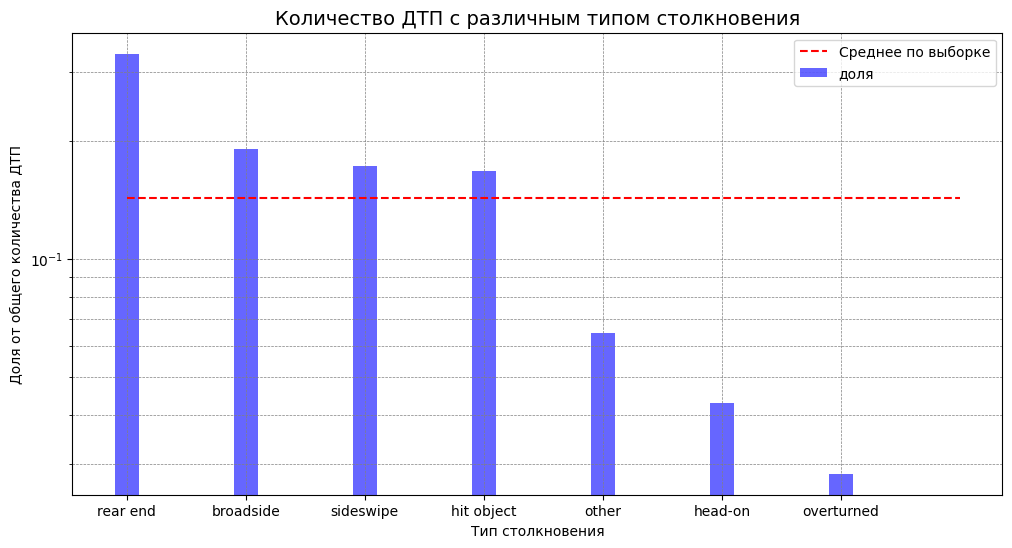

In [81]:
# Построим график для визуализации данных
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(12, 6))
ax.set_title('Количество ДТП с различным типом столкновения', fontsize=14)
ax.grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')
ax.set_xlabel('Тип столкновения')
ax.set_ylabel('Доля от общего количества ДТП')
ax.set_yscale('log')
x_axe = np.arange(type_of_collision_data.shape[0])
ax.set_xticks(x_axe)
ax.set_xticklabels(type_of_collision_data['type_of_collision'])
ax.bar(x=x_axe, height=type_of_collision_data['relative_frequency'], width=0.2,
         align='center', label='доля', color='blue', alpha=0.6)
ax.plot([0, type_of_collision_data.shape[0]],
         [type_of_collision_data['relative_frequency'].mean(),
          type_of_collision_data['relative_frequency'].mean()], linestyle='--', color='red', label='Среднее по выборке')
ax.legend()
plt.show()

По диаграммам можем заключить, что наибольшая частота всех ДТП - столкновение задней частью, на втором месте боковой удар, сторона и удар объекта.

####  Дополнительные участники ДТП

In [82]:
# Выберем требуемые данные по дополнительным участникам
query = '''
SELECT involved,       
       col_cnt/SUM(col_cnt) OVER() AS relative_frequency
FROM   (SELECT motor_vehicle_involved_with AS involved,
               COUNT(*) AS col_cnt
        FROM collisions
        GROUP BY motor_vehicle_involved_with
        ORDER BY motor_vehicle_involved_with) AS involved_cnt
'''
involved_data = pd.read_sql_query(query, con=engine)
involved_data

involved  relative_frequency
0                          animal            0.004422
1                         bicycle            0.029794
2                    fixed object            0.162101
3  motor vehicle on other roadway            0.007022
4                   non-collision            0.028504
5             other motor vehicle            0.636485
6                    other object            0.051912
7            parked motor vehicle            0.074588
8                           train            0.000301
9                            None            0.004871

In [83]:
involved_data['involved'] = involved_data['involved'].fillna('no info')
involved_data = involved_data.sort_values(by='relative_frequency', ascending=False)

Рассмотрим частоту ДТП при различном количестве участников ДТП.

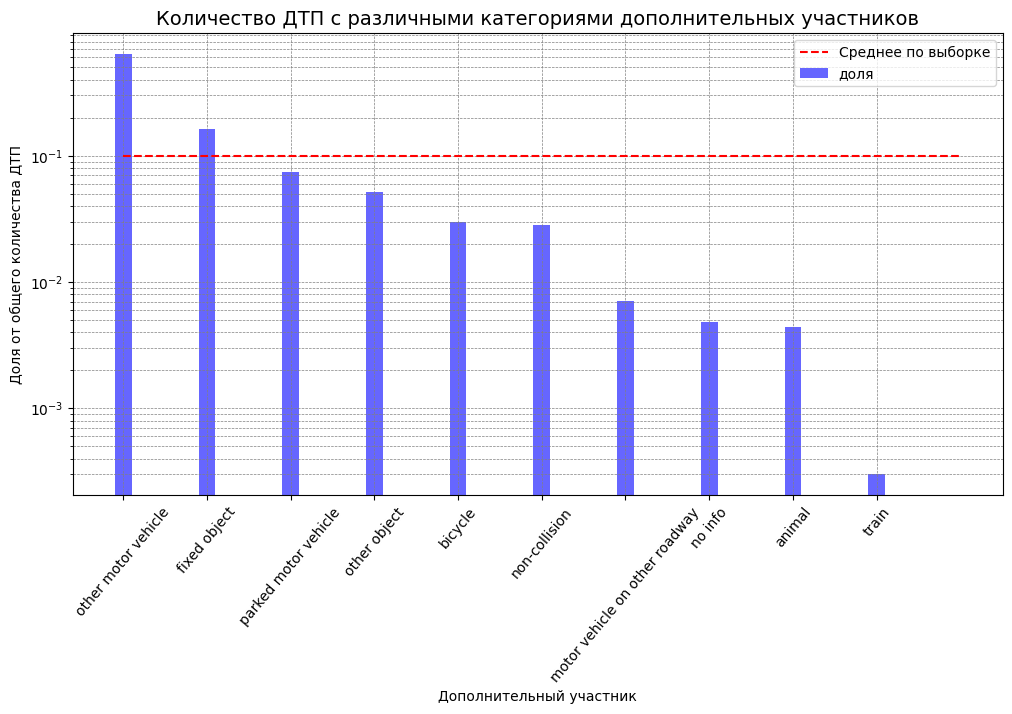

In [84]:
# Построим график для визуализации данных
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(12, 6))
ax.set_title('Количество ДТП с различными категориями дополнительных участников', fontsize=14)
ax.grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')
ax.set_xlabel('Дополнительный участник')
ax.set_ylabel('Доля от общего количества ДТП')
ax.set_yscale('log')
x_axe = np.arange(involved_data.shape[0])
ax.set_xticks(x_axe)
ax.set_xticklabels(involved_data['involved'], rotation=50)
ax.bar(x=x_axe, height=involved_data['relative_frequency'], width=0.2,
         align='center', label='доля', color='blue', alpha=0.6)
ax.plot([0, involved_data.shape[0]],
         [involved_data['relative_frequency'].mean(),
          involved_data['relative_frequency'].mean()], linestyle='--', color='red', label='Среднее по выборке')
ax.legend()
plt.show()

По диаграммам можем заключить, что наибольшая частота всех ДТП - либо столкновение с другим автомобилем, либо со стационарным объектом.

####  Функционирование устройства управления

In [85]:
# Выберем требуемые данные по дополнительным участникам
query = '''
SELECT control_device,       
       col_cnt/SUM(col_cnt) OVER() AS relative_frequency
FROM   (SELECT control_device,
               COUNT(*) AS col_cnt
        FROM collisions
        GROUP BY control_device
        ORDER BY control_device) AS involved_cnt
'''
control_device_data = pd.read_sql_query(query, con=engine)
control_device_data

control_device  relative_frequency
0      functioning            0.336321
1             none            0.654416
2  not functioning            0.002738
3         obscured            0.000521
4             None            0.006005

In [86]:
control_device_data['control_device'] = control_device_data['control_device'].fillna('no info')
control_device_data = control_device_data.sort_values(by='relative_frequency', ascending=False)

Рассмотрим частоту ДТП при различном количестве участников ДТП.

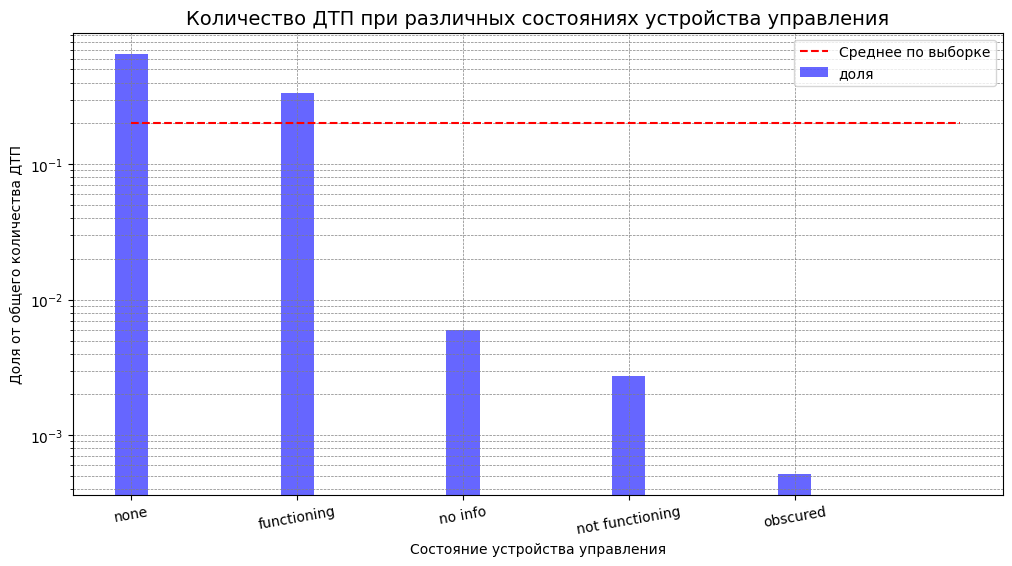

In [87]:
# Построим график для визуализации данных
fig, ax = plt.subplots(ncols=1, nrows=1,
                       figsize=(12, 6))
ax.set_title('Количество ДТП при различных состояниях устройства управления', fontsize=14)
ax.grid(color='gray', which='both', linewidth = 0.5, linestyle = '--')
ax.set_xlabel('Состояние устройства управления')
ax.set_ylabel('Доля от общего количества ДТП')
ax.set_yscale('log')
x_axe = np.arange(control_device_data.shape[0])
ax.set_xticks(x_axe)
ax.set_xticklabels(control_device_data['control_device'], rotation=10)
ax.bar(x=x_axe, height=control_device_data['relative_frequency'], width=0.2,
         align='center', label='доля', color='blue', alpha=0.6)
ax.plot([0, control_device_data.shape[0]],
         [control_device_data['relative_frequency'].mean(),
          control_device_data['relative_frequency'].mean()], linestyle='--', color='red', label='Среднее по выборке')
ax.legend()
plt.show()

По диаграммам можем заключить, что наибольшая частота всех ДТП в случае отсутствия устройства управления.

## Создайте модель для оценки водительского риска

### Подготовка набора данных для моделирования

#### Загрузка данных из базы

С учётом исследований, проведённых в разделе 4, для моделирования выберем следующие факторы:
- день недели (поле collision_date из таблицы collisions),
- состояние поверхности дороги (поле road_surface из таблицы collisions),
- состояние дороги (поле road_condition_1 из таблицы collisions),
- основной фактор аварии и категория нарушения (primary_collision_factor, pcf_violation_category из таблицы collisions),
- трезвость и физическое состояние водителя (поля party_sobriety, party_drug_physical из таблицы parties),
- тип транспортного средства, тип коробки передач, срок службы транспортного средства (поля vehicle_type, vehicle_transmission, vehicle_age из таблицы vehicle),
- возможность говорить по телефону по громкой связи (поле cellphone_in_use из таблицы parties),
- погода, освещённость, время (поля weather_1, lighting, collision_time из таблицы collisions),
- код локации (поле county_city_location из таблицы collisions),
- тип дороги (поле location_type из таблицы collisions).

Выберем тип виновника — только машина (car).  
Возьмём случаи, когда ДТП привело к любым повреждениям автомобиля любого из участников, кроме типа SCRATCH (царапина).  
Для моделирования возьмём данные только за 2012 год.

In [88]:
# Выберем требуемые данные
query = '''
SELECT p.at_fault,
       c.county_city_location AS location,
       c.location_type AS road_type,
       v.vehicle_type AS vehicle_type,
       v.vehicle_transmission AS transmission,
       p.cellphone_in_use AS cellphone,
       v.vehicle_age AS vehicle_age,
       CASE EXTRACT(dow FROM c.collision_date::date)
                 WHEN 1 THEN 'Monday'
                 WHEN 2 THEN 'Tuesday'
                 WHEN 3 THEN 'Wednesday'
                 WHEN 4 THEN 'Thursday'
                 WHEN 5 THEN 'Friday'
                 WHEN 6 THEN 'Saturday'
                 WHEN 0 THEN 'Sunday'
            END AS dow,                   
       EXTRACT(hour FROM c.collision_time) AS hour,
       c.road_surface AS road_surface,
       c.road_condition_1 AS road_condition,
       c.primary_collision_factor AS collision_factor,
       c.pcf_violation_category AS violation,
       p.party_sobriety AS sobriety,
       p.party_drug_physical AS drug_physical,
       c.weather_1 AS weather,
       c.lighting AS lighting
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car'
  AND c.collision_damage<>'scratch'
  AND c.collision_date::date BETWEEN '01.01.2012' AND '01.01.2013'
'''
df = pd.read_sql_query(query, con=engine)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56253 entries, 0 to 56252
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   at_fault          56253 non-null  int64  
 1   location          56253 non-null  object 
 2   road_type         25932 non-null  object 
 3   vehicle_type      56253 non-null  object 
 4   transmission      55394 non-null  object 
 5   cellphone         51782 non-null  float64
 6   vehicle_age       54559 non-null  float64
 7   dow               56253 non-null  object 
 8   hour              56165 non-null  float64
 9   road_surface      55905 non-null  object 
 10  road_condition    56004 non-null  object 
 11  collision_factor  56142 non-null  object 
 12  violation         55487 non-null  object 
 13  sobriety          55381 non-null  object 
 14  drug_physical     2858 non-null   object 
 15  weather           56085 non-null  object 
 16  lighting          56099 non-null  object

#### Пропуски, аномалии и типы

Видим, что в данных имеются пропуски. Обработаем их.

In [90]:
# Посчитаем пропуски.
display(df.isna().sum().sort_values(ascending=False))
df.isna().mean().sort_values(ascending=False)

drug_physical       53395
road_type           30321
cellphone            4471
vehicle_age          1694
sobriety              872
transmission          859
violation             766
road_surface          348
road_condition        249
weather               168
lighting              154
collision_factor      111
hour                   88
location                0
dow                     0
vehicle_type            0
at_fault                0
dtype: int64

drug_physical       0.949194
road_type           0.539011
cellphone           0.079480
vehicle_age         0.030114
sobriety            0.015501
transmission        0.015270
violation           0.013617
road_surface        0.006186
road_condition      0.004426
weather             0.002987
lighting            0.002738
collision_factor    0.001973
hour                0.001564
location            0.000000
dow                 0.000000
vehicle_type        0.000000
at_fault            0.000000
dtype: float64

Видим пропуски в колонках: `drug_physical`, `road_type`, `cellphone`, `vehicle_age`, `sobriety`, `transmission`, `violation`, `road_surface`, `road_condition`, `weather`, `lighting`, `collision_factor`, `hour`. Заполнение пропусков будем выполнять следующим образом:
- строки с пропущенным часом и сроком службы удалим,
- в столбце `cellphone` заменим 1 на 'yes', 0 - на 'no', пропуски - на 'no_info',
- солбцы `sobriety`, `drug_physical` объединим по аналогии с тем, как это делали в п.4.5.1 исследования,
- пропуски в остальных столбцах заполним заглушкой 'no info'.

In [91]:
# строки с пропущенным часом удалим
df = df[~df['hour'].isna()].copy()

In [92]:
# Заполним пропуски sobriety и drug_physical заглушкой
df['sobriety'] = df['sobriety'].fillna('filled_NA')
df['drug_physical'] = df['drug_physical'].fillna('filled_NA')
# Рассмотрим, какие категории состояния можно выделить
df['condition'] = df['sobriety'] + '-' + df['drug_physical']
df['condition'].value_counts(dropna=False)

condition
had not been drinking-filled_NA                                 48033
had been drinking, under influence-filled_NA                     4213
impairment unknown-G                                             1230
had been drinking, not under influence-filled_NA                  533
filled_NA-filled_NA                                               326
filled_NA-under drug influence                                    297
had not been drinking-under drug influence                        288
not applicable-not applicable                                     250
had been drinking, impairment unknown-filled_NA                   228
had been drinking, under influence-under drug influence           212
had not been drinking-sleepy/fatigued                             190
filled_NA-sleepy/fatigued                                         162
filled_NA-impairment - physical                                    86
had not been drinking-impairment - physical                        31
had been d

In [93]:
# Изменим наименования категорий
# Изменим наименования категорий
replace_map = {'had been drinking, impairment unknown-impairment - physical':'пил-ухудшение состояния',
       'had been drinking, impairment unknown-sleepy/fatigued':'пил-сонный, уставший',
       'had been drinking, impairment unknown-under drug influence':'пил-под действием лекарств',
       'had been drinking, impairment unknown-filled_NA':'пил (влияние не известно)',
       'had been drinking, not under influence-impairment - physical':'пил-ухудшение состояния',
       'had been drinking, not under influence-sleepy/fatigued':'пил-сонный, уставший',
       'had been drinking, not under influence-under drug influence':'пил-под действием лекарств',
       'had been drinking, not under influence-filled_NA':'пил (не под влиянием)',
       'had been drinking, under influence-impairment - physical':'пил-ухудшение состояния',
       'had been drinking, under influence-sleepy/fatigued':'пил-сонный, уставший',
       'had been drinking, under influence-under drug influence':'пил-под действием лекарств',
       'had been drinking, under influence-filled_NA':'пил (под влиянием)',
       'had not been drinking-impairment - physical':'ухудшение состояния',
       'had not been drinking-sleepy/fatigued':'сонный, уставший',
       'had not been drinking-under drug influence':'под действием лекарств',
       'had not been drinking-filled_NA':'не пил',
       'impairment unknown-G':'no info',
       'not applicable-not applicable':'не оценивался',
       'filled_NA-impairment - physical':'ухудшение состояния',
       'filled_NA-sleepy/fatigued':'сонный, уставший',
       'filled_NA-under drug influence':'под действием лекарств',
       'filled_NA-filled_NA':'no info'
}
df['condition'] = df['condition'].replace(replace_map)
df['condition'].value_counts(dropna=False)

condition
не пил                        48033
пил (под влиянием)             4213
no info                        1556
под действием лекарств          585
пил (не под влиянием)           533
сонный, уставший                352
пил-под действием лекарств      256
не оценивался                   250
пил (влияние не известно)       228
ухудшение состояния             117
пил-сонный, уставший             38
пил-ухудшение состояния           4
Name: count, dtype: int64

In [94]:
# Удалим лишние столбцы
df = df.drop(['sobriety', 'drug_physical'], axis=1)

In [95]:
# Заполним пропуски cellphone заглушкой, заменим значения
df['cellphone'] = df['cellphone'].fillna('no info')
df['cellphone'] = df['cellphone'].replace({0:'no', 1:'yes'})

In [96]:
# пропуски в остальных столбцах, кроме возраста авто заполним заглушкой 'no info'
df[['road_type', 'transmission', 'violation', 'road_surface', 'road_condition', 'weather', 'lighting',
'collision_factor']] = \
df[['road_type', 'transmission', 'violation', 'road_surface', 'road_condition', 'weather', 'lighting',
'collision_factor']].fillna('no_info')

In [97]:
# Тип в столбце с hour заменим на int
df['hour'] = df['hour'].astype('int')

In [98]:
# Изучим данные по возрасту
df['vehicle_age'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  19., 161.,  nan])

In [99]:
# Посмотрим долю строк с пропусками и со странным значением возраста 161
df[(df['vehicle_age']==161)|df['vehicle_age'].isna()]['at_fault'].count()/df.shape[0]

0.0301255230125523

In [100]:
# Предпосылок для обоснованного заполнения пропусков по сроку службы авто у нас нет
# Удалим строки с пропусками возраста
df = df.loc[~((df['vehicle_age']==161)|df['vehicle_age'].isna())].copy()
df['vehicle_age'] = df['vehicle_age'].astype('int')

In [101]:
# Проверим балансировку классов
df['at_fault'].mean()

0.5043232427073964

In [102]:
# Проверим датасет после всех изменений
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54473 entries, 0 to 56252
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   at_fault          54473 non-null  int64 
 1   location          54473 non-null  object
 2   road_type         54473 non-null  object
 3   vehicle_type      54473 non-null  object
 4   transmission      54473 non-null  object
 5   cellphone         54473 non-null  object
 6   vehicle_age       54473 non-null  int32 
 7   dow               54473 non-null  object
 8   hour              54473 non-null  int32 
 9   road_surface      54473 non-null  object
 10  road_condition    54473 non-null  object
 11  collision_factor  54473 non-null  object
 12  violation         54473 non-null  object
 13  weather           54473 non-null  object
 14  lighting          54473 non-null  object
 15  condition         54473 non-null  object
dtypes: int32(2), int64(1), object(13)
memory usage: 6.6+ MB


Пропуски обработаны, типы приведены в порядок

#### Разделение выборки

In [103]:
# Разделим датасет на обучающую и тестовую выборки
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
print('Обучающая выборка: ', train.shape[0], ', ',  round(train.shape[0]/df.shape[0], 2), sep='')
print('Тестовая выборка: ', test.shape[0], ', ', round(test.shape[0]/df.shape[0], 2), sep='')

Обучающая выборка: 43578, 0.8
Тестовая выборка: 10895, 0.2


In [104]:
train.columns

Index(['at_fault', 'location', 'road_type', 'vehicle_type', 'transmission',
       'cellphone', 'vehicle_age', 'dow', 'hour', 'road_surface',
       'road_condition', 'collision_factor', 'violation', 'weather',
       'lighting', 'condition'],
      dtype='object')

In [105]:
# Разделим признаки
X = ['location', 'road_type', 'vehicle_type', 'transmission',
       'cellphone', 'vehicle_age', 'dow', 'hour', 'road_surface',
       'road_condition', 'collision_factor', 'violation', 'weather',
       'lighting', 'condition']
y = ['at_fault']

In [106]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include='object').columns.to_list()
cat_features

['location',
 'road_type',
 'vehicle_type',
 'transmission',
 'cellphone',
 'dow',
 'road_surface',
 'road_condition',
 'collision_factor',
 'violation',
 'weather',
 'lighting',
 'condition']

In [107]:
# Составим список числовых признаков
num_features = train[X].select_dtypes(include=['int64', 'int32']).columns.to_list()
num_features

['vehicle_age', 'hour']

#### Создание трансформеров и пайплайнов

Для решения поставленной задачи будем использовать модель линейной регрессии, модель случайного леса, а также классификаторы на основе градиентного бустинга из библиотеки catboost и библиотеки LightGBM.
Для оценки качества и выбора модели будем использовать площадь под ROC (roc auc), чтоб понять, насколько качественно модель выполняет разделение классов.

В дальнейшем, чтоб максимизировать долю правильных предсказаний ДТП (TPR или recall) при разумной доле ошибочно предсказанных ДТП (FPR) подберём значение порога для выбранной модели с максимальной площадью под ROC.

In [108]:
# Преобразователь признаков для модели логистической регрессии
col_transformer_ridge = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    (MinMaxScaler(), num_features),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Пайплайн для модели логистической регрессии
model_ridge = RidgeClassifier(random_state=RANDOM_STATE)
pipeline_ridge = make_pipeline(col_transformer_ridge, model_ridge)

param_grid_ridge = {
    'ridgeclassifier__max_iter': range(1000, 30001, 2000),
    'ridgeclassifier__alpha': [100, 50, 20, 10, 1, 0.5, 0.1, 0.05, 0.01],   
}

gs_ridge_pl = GridSearchCV(
    pipeline_ridge,
    param_grid=param_grid_ridge,
    scoring='roc_auc',
    cv=4,
    n_jobs=-1
)

In [109]:
# Преобразователь признаков для модели случайного леса и модели LightGBM
col_transformer_forest = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
    (MinMaxScaler(), num_features),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Пайплайн для модели случайного леса
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
pipline_rf = make_pipeline(col_transformer_forest, model_forest)

param_grid_rf = {
    'randomforestclassifier__n_estimators': range(10, 101, 5),
    'randomforestclassifier__max_depth': range(2, 31, 2),
    'randomforestclassifier__min_samples_split': np.arange(0.1, 0.7, step=0.05),
    'randomforestclassifier__min_samples_leaf': range(1, 11, 1)
}

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1,
    cv=4,
    random_state=RANDOM_STATE
)

In [110]:
# Преобразователь признаков для модели catboost
col_transformer_catboost = make_column_transformer(
    (MinMaxScaler(), num_features),
    remainder='passthrough',
    verbose_feature_names_out=False
)

### Модель логистической регрессии

In [111]:
# Логистическая регрессия
gs_ridge_pl.fit(train[X], train[y].values.ravel())
gs_ridge_best_score = gs_ridge_pl.best_score_
gs_ridge_best_params = gs_ridge_pl.best_params_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_ridge_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_best_params}')

best_score: 0.7530470458733248
best_params: {'ridgeclassifier__alpha': 50, 'ridgeclassifier__max_iter': 1000}


### Модель на основе случайного леса

In [112]:
# Модель на основе случайного леса
gs_rf.fit(train[X], train[y].values.ravel())
gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_rf_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_rf_best_params}')

best_score: 0.7174320947334062
best_params: {'randomforestclassifier__n_estimators': 20, 'randomforestclassifier__min_samples_split': 0.20000000000000004, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__max_depth': 18}


### Градиентный бустинг (библиотека  LightGBM)

In [113]:
# Данные для модели
X_train_LGBM = pd.DataFrame(
    col_transformer_forest.fit_transform(train[X]),
    columns=col_transformer_forest.get_feature_names_out()
)
X_test_LGBM = pd.DataFrame(
    col_transformer_forest.fit_transform(test[X]),
    columns=col_transformer_forest.get_feature_names_out()
)
# Модель
lgbm = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)

In [114]:
# Данные для подбора гиперпараметров
grid_param_lgbm = {'learning_rate': np.arange(0.01, 0.31, 0.05),
                   'reg_lambda':np.arange(0.05, 0.21, 0.05)}
# Градиентный бустинг (библиотека LightGBM) с ordinal encoding
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=grid_param_lgbm, scoring='roc_auc',
                         cv=4, n_jobs=-1)
grid_lgbm.fit(X_train_LGBM, train[y].values.ravel())

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {grid_lgbm.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {grid_lgbm.best_params_}')

best_score: 0.7816599978837183
best_params: {'learning_rate': 0.060000000000000005, 'reg_lambda': 0.1}


### Градиентный бустинг (библиотека catboost)

In [115]:
# Данные для модели
X_train_cb = pd.DataFrame(
    col_transformer_catboost.fit_transform(train[X]),
    columns=col_transformer_catboost.get_feature_names_out()
)
X_test_cb = pd.DataFrame(
    col_transformer_catboost.fit_transform(test[X]),
    columns=col_transformer_catboost.get_feature_names_out()
)

# Модель
cb = CatBoostClassifier(cat_features=cat_features,
                        eval_metric='AUC',
                        random_seed=RANDOM_STATE,
                        logging_level='Silent',
                        early_stopping_rounds=20)

In [116]:
# Данные для подбора гиперпараметров
grid_param_cb = {'learning_rate': np.arange(0.01, 0.32, 0.1),
                 'iterations':[1000]
                }
# Градиентный бустинг (библиотека catboost)
grid_cb = GridSearchCV(estimator=cb, param_grid=grid_param_cb, scoring='roc_auc',
                         cv=4, n_jobs=-1)
grid_cb.fit(X_train_cb, train[y])

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {grid_cb.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {grid_cb.best_params_}')

best_score: 0.7987654894770897
best_params: {'iterations': 1000, 'learning_rate': 0.11}


### Выбор модели

C:\Users\Дмитрий\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


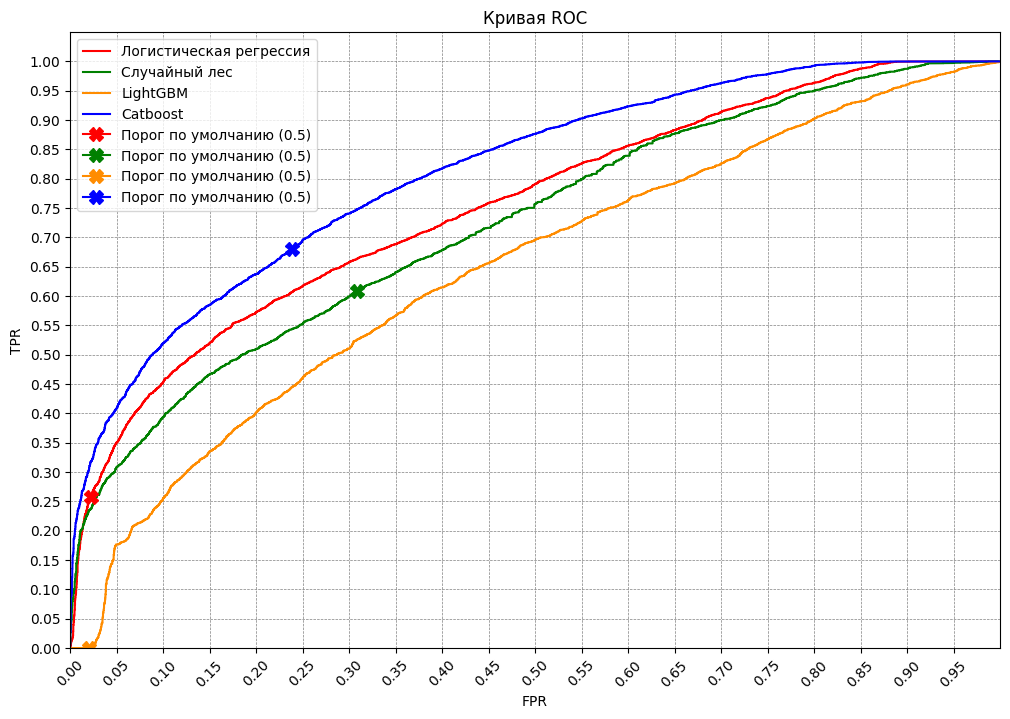

In [118]:
# Построим кривую ROC и отметим точку, соответствующую обученной модели
# Логистическая регрессия
probabilities_lr = gs_ridge_pl.decision_function(test[X])
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test[y], probabilities_lr)
# Модель на основе случайного леса
probabilities_forest = gs_rf.predict_proba(test[X])
probabilities_one_forest = probabilities_forest[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test[y], probabilities_one_forest)
# Модель из библиотеки LightGBM
probabilities_lgbm = grid_lgbm.predict_proba(X_test_LGBM)
probabilities_one_lgbm = probabilities_lgbm[:, 1]
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(test[y], probabilities_one_lgbm)
# Модель из библитоки catboost
probabilities_cb = grid_cb.predict_proba(X_test_cb)
probabilities_one_cb = probabilities_cb[:, 1]
fpr_cb, tpr_cb, thresholds_cb = roc_curve(test[y], probabilities_one_cb)

# Кривые ROC
plt.figure(figsize=(12, 8))
plt.step(fpr_lr, tpr_lr, where='post', label='Логистическая регрессия', color='red')
plt.step(fpr_rf, tpr_rf, where='post', label='Случайный лес', color='green')
plt.step(fpr_lgbm, tpr_lgbm, where='post', label='LightGBM', color='darkorange')
plt.step(fpr_cb, tpr_cb, where='post', label='Catboost', color='blue')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xticks(np.arange(0, 1.0, step=0.05), rotation=45)
plt.yticks(np.arange(0, 1.05, step=0.05))
plt.grid(color='gray', linewidth=0.5, linestyle='--')
plt.title('Кривая ROC')

# Точки обученных моделей на кривой
# Логистическая регрессия
plt.plot(
    fpr_lr[thresholds_lr == thresholds_lr[thresholds_lr >= 0.5][-1]],
    tpr_lr[thresholds_lr == thresholds_lr[thresholds_lr >= 0.5][-1]],
    color='red',
    marker='X',
    markersize=10,
    label='Порог по умолчанию (0.5)'
)


# Модель на основе случайного леса
plt.plot(
    fpr_rf[thresholds_rf == thresholds_rf[thresholds_rf >= 0.5][-1]],
    tpr_rf[thresholds_rf == thresholds_rf[thresholds_rf >= 0.5][-1]],
    color='green',
    marker='X',
    markersize=10,
    label='Порог по умолчанию (0.5)'
)
# Модель из библиотеки LightGBM
plt.plot(
    fpr_lgbm[thresholds_lgbm == thresholds_lgbm[thresholds_lgbm >= 0.5][-1]],
    tpr_lgbm[thresholds_lgbm == thresholds_lgbm[thresholds_lgbm >= 0.5][-1]],
    color='darkorange',
    marker='X',
    markersize=10,
    label='Порог по умолчанию (0.5)'
)
# Модель из библитоки catboost
plt.plot(
    fpr_cb[thresholds_cb == thresholds_cb[thresholds_cb >= 0.5][-1]],
    tpr_cb[thresholds_cb == thresholds_cb[thresholds_cb >= 0.5][-1]],
    color='blue',
    marker='X',
    markersize=10,
    label='Порог по умолчанию (0.5)'
)

plt.legend()
plt.show()

Для дальнейшей работы принимаем модель из библиотеки Catboost, которая позволит с помощью изменения порога добиться метрики recall $\approx 0,8-0,85$ при сравнительно небольшой доле ошибок FPR $\approx 0,4-0,45$. С точки зрения бизнеса это позволит в 80-85% случаев верно предсказать риск ДТП, и лишь в 40-45% предсказать его избыточно.

In [119]:
# Проверим метрику на тестовой выборке
print(f'test_score: {roc_auc_score(test[y], probabilities_one_cb)}')

test_score: 0.8112139670151175


In [122]:
# Требуемое значение порога, чтоб значение TPR было не ниже 0,85
th_85 = thresholds_cb[tpr_cb>=0.85][0]
predicted_cb_th_85 = (probabilities_one_cb>th_85).astype('int')

# проверим правильность выбранног порога
tn, fp, fn, tp = confusion_matrix(test[y], predicted_cb_th_85).ravel()
tpr = tp/(tp + fn)
fpr = fp/(fp + tn)
print(f'TPR: {tpr:.3f}, FPR: {fpr:.3f}')

TPR: 0.850, FPR: 0.454


## Проведите анализ важности факторов ДТП

In [123]:
# Обучим модель с выявленными параметрами
# Модель
cb = CatBoostClassifier(cat_features=cat_features,
                        eval_metric='AUC',
                        random_seed=RANDOM_STATE,
                        logging_level='Silent',
                        early_stopping_rounds=20,
                        learning_rate=0.11,
                        iterations=1000)
cb.fit(X_train_cb, train[y])

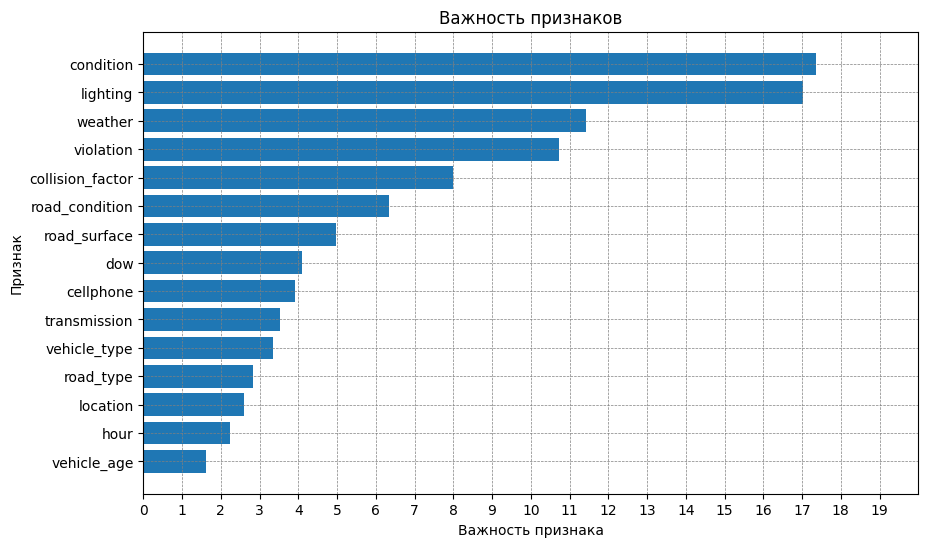

In [124]:
# Проверим важность признаков с точки зрения модели
importances = pd.Series(cb.get_feature_importance(), index=cb.feature_names_)
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.xlim([0, 20])
plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances.sort_values())
plt.show()

Наиболее важные признаки:
- condition, состояние водителя,
- lighting, условия освещённости,
- weather, погодные условия,
- violation, категория нарушения правил дорожного движения,
- collision_factor, основной фактор аварии,
- road_condition, состояние дороги, дорожной обстановки.  

<b> Исходя из полученных данных, можно заключить, что создать адекватную системы оценки водительского риска при выдаче авто *возможно*, если учитывать факторы, использованные при моделировании.</b>

Для оценки некоторых факторов можно выполнить технические мероприятия:
- установить алкорамку в авто, проверять алкоголь в выдыхаемом воздухе,
- получать и анализировать специальной программой на опьянение/усталость видеозапись от водителя, на которой он в режиме съёмки читает заданный текст,
- своевременно получать актуальную информацию в навигационную систему о дорожной обстановке (ремонты, заторы, препятствия и т.п.) ,
- своевременно получать информацию о погоде,
- оснастить автомобиль средствами контроля скорости (скоростной режим).

## Выводы

В ходе работы выполнено:
- подключение к базе данных и первичный анализ таблиц,
- статистический анализ факторов ДТП,
- выбор факторов для модели машинного обучения, с учётом пожеланий заказчика,
- выбрана метрик для оценки моделей (AUC ROC) и целевая (recall),
- проработано несколько моделей (логистическая регрессия, на основе случайного леса, модели градиентного бустинга из библиотек LightGBM и Catboost, выбрана лучшая,
- проведён анализ важности признаков, выработаны предложения по меропритиям для заказчика.